<a href="https://colab.research.google.com/github/yucha17/autos/blob/main/%D0%90%D0%BD%D1%82%D0%B8%D1%84%D1%80%D0%BE%D0%B4_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Название проекта**

Построение антифрод модели
_____
**Описание исследования.**

Нам необходимо проанализировать информацию о клиетах с целью написания модели машинного обучения, определяющей мошенник или обычный клиент подает заявление на кредит. Для этого нам необходимо провести предобработку данных, где определимся что делать с пропусками, обработаем колонки и добавим новые в случае необходимости и разберемся с пропусками. Выполним исследовательский анализ данных, посмотрим что из себя представляют наши данные, визуализируем их и попробуем найти возможные закономерности и выбросы. Потом приступим к обучению несколько моделей для определения наиболее подходящей. Как метрику качества будем использовать AUC-ROC. После выбора наилучшей модели проверим ее на тестовой выборке, а так же подведем итог нашего исследования.
_____
**Цель исследования.**
    
Построить предсказательную модель определения мошенничества
   
_____
**Исходные данные.**
    
В нашем распоряжении 4 датасета с информацией о поведении клиентов, полной кредитной истории, данных анкеты и целевой фиче. Так же добавляем справочник регионов.

# Предобработка данных

Загрузим необходимые библиотеки и датасеты.

In [7]:
pip install catboost

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

Отключим ограничение пандас на вывод

In [9]:
pd.options.display.max_columns =  None
pd.options.display.max_rows =  None

К датасетам, что нам дали, добавим справочник регионов, чтобы воспользоваться им при анализе таблицы profile.

In [10]:
behavior = pd.read_csv('/content/drive/MyDrive/Тестовое/behavior_task.csv')
ki = pd.read_csv('/content/drive/MyDrive/Тестовое/ki_loans_task.csv')
profile = pd.read_csv('/content/drive/MyDrive/Тестовое/profile_task.csv')
target = pd.read_csv('/content/drive/MyDrive/Тестовое/target_task.csv')
region = pd.read_excel('/content/drive/MyDrive/Тестовое/Справочник регионов.xlsx')

Сначала рассмотрим наш справочник

In [11]:
region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Код           86 non-null     int64 
 1   Наименование  86 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.5+ KB


Справочник содержит код региона и его наименование, теперь перейдем к просмотру наших основных датасетов.

Создадим функцию для вывода первых 5 строк, типов данных, основыных показателей, количества пропусков и количества дубликатов.

In [12]:
def about_data(df):
    print('Первые 5 строк датасета')
    display(df.head())
    print()
    print()
    print('Типы данных')
    print(df.info())
    print()
    print()
    print('Уникальные значения в графах')
    for i in df.columns:
        print('Графа', i)
        print(df[i].sort_values().unique())
        print()
    print()
    print()
    print('Основные показатели')
    print(df.describe())
    print()
    print()
    print('Количество пропусков')
    print(df.isna().sum())
    print()
    print()
    print('Количество дубликатов:',df.duplicated().sum())

Теперь перейдем к датасетам

In [13]:
about_data(behavior)

Первые 5 строк датасета


,ID,SAVE_STAMP,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59
0,19622849,2022-03-01 10:27:26,1.0,NaN,18.0,0.0,2.0,1.0,0.0,0.0,1.0,2.0,NaN,1.0,Mobile Phone,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,0.0,0.0,3.0,1.0,0.0,1.0,0.0,NaN,0.0,0.13,2.0,6.0,1.0,1.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,2.0,1.0,0.0,14.0,4.0,0.194,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,19623228,2022-03-01 10:36:55,0.0,NaN,14.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,3.0,Desktop,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,3.0,1.0,0.0,1.0,0.0,NaN,0.0,0.93,0.0,4.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,2.0,0.0,0.0,24.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,19673010,2022-03-02 16:48:01,0.0,NaN,25.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,3.0,Mobile Phone,1.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,0.0,0.0,3.0,1.0,0.0,1.0,NaN,1.0,0.0,0.67,0.0,15.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,5.0,1.0,0.0,117.0,0.0,0.000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,19624134,2022-03-01 11:01:23,0.0,NaN,21.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,NaN,2.0,Mobile Phone,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,5.0,0.0,0.0,1.0,0.0,NaN,0.0,1.00,0.0,7.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,1.0,1.0,0.0,47.0,0.0,0.092,1.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0
4,19631797,2022-03-01 14:12:59,0.0,NaN,18.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,3.0,Mobile Phone,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,5.0,1.0,1.0,1.0,NaN,2.0,0.0,0.17,0.0,16.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,1.0,1.0,0.0,75.0,0.0,0.000,1.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0




Типы данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34215 entries, 0 to 34214
Data columns (total 62 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          34215 non-null  int64  
 1   SAVE_STAMP  34215 non-null  object 
 2   feature_0   33872 non-null  float64
 3   feature_1   0 non-null      float64
 4   feature_2   33829 non-null  float64
 5   feature_3   33872 non-null  float64
 6   feature_4   33872 non-null  float64
 7   feature_5   33872 non-null  float64
 8   feature_6   33860 non-null  float64
 9   feature_7   33859 non-null  float64
 10  feature_8   33829 non-null  float64
 11  feature_9   33872 non-null  float64
 12  feature_10  1519 non-null   object 
 13  feature_11  33872 non-null  float64
 14  feature_12  33845 non-null  object 
 15  feature_13  29403 non-null  float64
 16  feature_14  33872 non-null  float64
 17  feature_15  33872 non-null  float64
 18  feature_16  33872 non-null  float64
 19  feature_17 

У нас достаточно широкая таблица с большим количеством признаков. У многих из них тип флоат, хотя значения целочисленные. Так же есть незаполненные столбцы, сразу удалим их, они не несут для нас смысловой нагрузки. Не обошлось и без пропусков в данных, чаще всего фигурирует число 343, думаю эти строки можно будет удалить. И так же можно удалить 2 дубликата. К списку лишних столбцов еще добавим SAVE_STAMP, так как в датасете с которым мы будем мержить он есть, и перейдем к изучению следующего датасета.

In [14]:
behavior = behavior.drop(labels = ['feature_1', 'feature_19', 'feature_35', 'SAVE_STAMP'], axis = 1)
behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34215 entries, 0 to 34214
Data columns (total 58 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          34215 non-null  int64  
 1   feature_0   33872 non-null  float64
 2   feature_2   33829 non-null  float64
 3   feature_3   33872 non-null  float64
 4   feature_4   33872 non-null  float64
 5   feature_5   33872 non-null  float64
 6   feature_6   33860 non-null  float64
 7   feature_7   33859 non-null  float64
 8   feature_8   33829 non-null  float64
 9   feature_9   33872 non-null  float64
 10  feature_10  1519 non-null   object 
 11  feature_11  33872 non-null  float64
 12  feature_12  33845 non-null  object 
 13  feature_13  29403 non-null  float64
 14  feature_14  33872 non-null  float64
 15  feature_15  33872 non-null  float64
 16  feature_16  33872 non-null  float64
 17  feature_17  33872 non-null  float64
 18  feature_18  33872 non-null  float64
 19  feature_20  10018 non-nul

Теперь перейдем к датасету с кредитными историями

In [15]:
about_data(ki)

Первые 5 строк датасета


,ID,SAVE_STAMP,CRED_TYPE,CRED_ACTIVE,CRED_ENDDATE_FACT,CRED_DATE,CRED_OWNER,CRED_SUM_LIMIT,LOAN_AMOUNT_START,DELAY5,DELAY30,DELAY60,DELAY90,DELAY_MORE,CRED_SUM_OVERDUE
0,19634661,2022-03-01 15:27:44,3,13,2018-06-19,2016-12-19,1,2177720,22000,0,0,0,0,0,0
1,19634661,2022-03-01 15:27:44,4,13,2012-09-05,2012-06-07,1,90000,22000,0,0,0,0,0,0
2,19634661,2022-03-01 15:27:44,4,13,2014-06-02,2012-10-05,1,100000,22000,0,0,0,0,0,0
3,19634661,2022-03-01 15:27:44,5,13,2016-04-05,2014-04-07,1,500000,22000,0,0,0,0,0,0
4,19634661,2022-03-01 15:27:44,5,13,2020-01-01,2017-09-08,1,1500000,22000,0,0,0,0,0,0




Типы данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523811 entries, 0 to 523810
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ID                 523811 non-null  int64 
 1   SAVE_STAMP         523811 non-null  object
 2   CRED_TYPE          523811 non-null  int64 
 3   CRED_ACTIVE        523811 non-null  int64 
 4   CRED_ENDDATE_FACT  523132 non-null  object
 5   CRED_DATE          523811 non-null  object
 6   CRED_OWNER         523811 non-null  int64 
 7   CRED_SUM_LIMIT     523811 non-null  int64 
 8   LOAN_AMOUNT_START  523811 non-null  int64 
 9   DELAY5             523811 non-null  int64 
 10  DELAY30            523811 non-null  int64 
 11  DELAY60            523811 non-null  int64 
 12  DELAY90            523811 non-null  int64 
 13  DELAY_MORE         523811 non-null  int64 
 14  CRED_SUM_OVERDUE   523811 non-null  int64 
dtypes: int64(12), object(3)
memory usage: 59.9+ MB
None




Данный датасет содержит кредитную историю клиентов и состоит из 523811 строк. Одному ID может соответствовать несколько строк, так как клиент мог иметь большое количество кредитов. Так же стоит отметить, что в датасете только один столбец имеет пропуски, их 679. Это фактическая дата закрытия займа, следовательно это еще открытые кредиты. Можем создать на основе него бинарный столбец с признаком есть ли открытые кредиты. Датасет имеет 6132 полных дубликата.

Перейдем к следующему датасету.

In [16]:
about_data(profile)

Первые 5 строк датасета


,ID,SAVE_STAMP,BIRTH_DAY,BIRTH_MONTH,BIRTH_YEAR,INCOME,CARD_EXPIRY_DATE,REG_REGION,RES_REGION,PASS_REGION,SIM_REGION,IP_REGION
0,20349194,2022-03-21 16:54:27,23,12,1997,50000.0,2029-06-30 23:59:59,5000000000000,5000000000000,Московская область,Москва и Московская область,Московская область
1,20592853,2022-03-28 20:25:18,4,12,1985,50000.0,2026-08-31 23:59:59,4700000000000,4700000000000,Ленинградская область,Санкт-Петербург и Ленинградская область,Санкт-Петербург
2,20489395,2022-03-25 20:16:57,27,10,1982,70000.0,2023-10-31 23:59:59,5200000000000,5200000000000,Нижегородская область,Нижегородская область,Нижегородская область
3,20305048,2022-03-20 12:02:34,22,3,1998,50000.0,2022-07-31 23:59:59,7700000000000,7700000000000,Москва,Москва и Московская область,Московская область
4,20393147,2022-03-22 23:11:21,23,10,1966,50000.0,2024-01-31 23:59:59,7700000000000,7700000000000,Москва,Москва и Московская область,Московская область




Типы данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34215 entries, 0 to 34214
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                34215 non-null  int64  
 1   SAVE_STAMP        34215 non-null  object 
 2   BIRTH_DAY         34215 non-null  int64  
 3   BIRTH_MONTH       34215 non-null  int64  
 4   BIRTH_YEAR        34215 non-null  int64  
 5   INCOME            34198 non-null  float64
 6   CARD_EXPIRY_DATE  34214 non-null  object 
 7   REG_REGION        34215 non-null  int64  
 8   RES_REGION        34215 non-null  int64  
 9   PASS_REGION       34192 non-null  object 
 10  SIM_REGION        34208 non-null  object 
 11  IP_REGION         33431 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 3.1+ MB
None


Уникальные значения в графах
Графа ID
[19612833 19612862 19612871 ... 20707345 20707356 20707380]

Графа SAVE_STAMP
['2022-03-01 00:04:10' '2022-03-01

Данный датасет содержит информацию общую информацию о клиенте. Есть пропуски и в этом датасете, больше всего их в столбце с регионом ip. Так же есть 2 дубликата, как и в датасете behavior. Коды регионов в не очень подходящем формате, а дата рождения разбита на 3 столбца.

Сразу приведем код региона в удобный вид

In [17]:
profile['RES_REGION'] = profile['RES_REGION']/100000000000
profile['REG_REGION'] = profile['REG_REGION']/100000000000
profile.head()

,ID,SAVE_STAMP,BIRTH_DAY,BIRTH_MONTH,BIRTH_YEAR,INCOME,CARD_EXPIRY_DATE,REG_REGION,RES_REGION,PASS_REGION,SIM_REGION,IP_REGION
0,20349194,2022-03-21 16:54:27,23,12,1997,50000.0,2029-06-30 23:59:59,50.0,50.0,Московская область,Москва и Московская область,Московская область
1,20592853,2022-03-28 20:25:18,4,12,1985,50000.0,2026-08-31 23:59:59,47.0,47.0,Ленинградская область,Санкт-Петербург и Ленинградская область,Санкт-Петербург
2,20489395,2022-03-25 20:16:57,27,10,1982,70000.0,2023-10-31 23:59:59,52.0,52.0,Нижегородская область,Нижегородская область,Нижегородская область
3,20305048,2022-03-20 12:02:34,22,3,1998,50000.0,2022-07-31 23:59:59,77.0,77.0,Москва,Москва и Московская область,Московская область
4,20393147,2022-03-22 23:11:21,23,10,1966,50000.0,2024-01-31 23:59:59,77.0,77.0,Москва,Москва и Московская область,Московская область


Тип данных изменился на флоат, надо будет его изменить.

Так же у нас есть составные наименования регионов, изменим их на простые: Архангельскую область, Московскую область, Республика Крым, Ленинградская область. И сразу заменим во всем датасете Москву и Санкт-Петербург на области.

In [18]:
profile['SIM_REGION'] = profile['SIM_REGION']. replace(['Архангельская область и Ненецкий автономный округ',
                                                        'Москва и Московская область',
                                                        'Республика Крым и Севастополь',
                                                        'Санкт-Петербург и Ленинградская область'], ['Архангельская область',
                                                                                                     'Московская область',
                                                                                                     'Республика Крым',
                                                                                                     'Ленинградская область'])


In [19]:
profile = profile. replace(['Москва',
                            'Санкт-Петербург'], ['Московская область',
                                                 'Ленинградская область'])

Соединим наш справочник с целевой таблицей и введем коды регионов.

In [20]:
profile = profile.merge(region, how='left', left_on='PASS_REGION', right_on='Наименование')
profile = profile.rename(columns={'Код': 'pass_region_code'})
profile = profile.drop(labels = ['Наименование'], axis = 1)

profile = profile.merge(region, how='left', left_on='SIM_REGION', right_on='Наименование')
profile = profile.rename(columns={'Код': 'sim_region_code'})

profile = profile.merge(region, how='left', left_on='IP_REGION', right_on='Наименование')
profile = profile.rename(columns={'Код': 'ip_region_code'})

In [21]:
profile.head()

,ID,SAVE_STAMP,BIRTH_DAY,BIRTH_MONTH,BIRTH_YEAR,INCOME,CARD_EXPIRY_DATE,REG_REGION,RES_REGION,PASS_REGION,SIM_REGION,IP_REGION,pass_region_code,sim_region_code,Наименование_x,ip_region_code,Наименование_y
0,20349194,2022-03-21 16:54:27,23,12,1997,50000.0,2029-06-30 23:59:59,50.0,50.0,Московская область,Московская область,Московская область,50.0,50.0,Московская область,50.0,Московская область
1,20592853,2022-03-28 20:25:18,4,12,1985,50000.0,2026-08-31 23:59:59,47.0,47.0,Ленинградская область,Ленинградская область,Ленинградская область,47.0,47.0,Ленинградская область,47.0,Ленинградская область
2,20489395,2022-03-25 20:16:57,27,10,1982,70000.0,2023-10-31 23:59:59,52.0,52.0,Нижегородская область,Нижегородская область,Нижегородская область,52.0,52.0,Нижегородская область,52.0,Нижегородская область
3,20305048,2022-03-20 12:02:34,22,3,1998,50000.0,2022-07-31 23:59:59,77.0,77.0,Московская область,Московская область,Московская область,50.0,50.0,Московская область,50.0,Московская область
4,20393147,2022-03-22 23:11:21,23,10,1966,50000.0,2024-01-31 23:59:59,77.0,77.0,Московская область,Московская область,Московская область,50.0,50.0,Московская область,50.0,Московская область


Удалим лишние столбцы

In [22]:
profile = profile.drop(labels = ['PASS_REGION', 'SIM_REGION', 'IP_REGION', 'Наименование_x', 'Наименование_y'], axis = 1)

In [23]:
profile.head()

,ID,SAVE_STAMP,BIRTH_DAY,BIRTH_MONTH,BIRTH_YEAR,INCOME,CARD_EXPIRY_DATE,REG_REGION,RES_REGION,pass_region_code,sim_region_code,ip_region_code
0,20349194,2022-03-21 16:54:27,23,12,1997,50000.0,2029-06-30 23:59:59,50.0,50.0,50.0,50.0,50.0
1,20592853,2022-03-28 20:25:18,4,12,1985,50000.0,2026-08-31 23:59:59,47.0,47.0,47.0,47.0,47.0
2,20489395,2022-03-25 20:16:57,27,10,1982,70000.0,2023-10-31 23:59:59,52.0,52.0,52.0,52.0,52.0
3,20305048,2022-03-20 12:02:34,22,3,1998,50000.0,2022-07-31 23:59:59,77.0,77.0,50.0,50.0,50.0
4,20393147,2022-03-22 23:11:21,23,10,1966,50000.0,2024-01-31 23:59:59,77.0,77.0,50.0,50.0,50.0


Тип данных в новых столбцах флоат, надо будет заменить на целочисленные значения.

In [24]:
about_data(target)

Первые 5 строк датасета


,ID,AF1_TARGET
0,19614912,1.0
1,19615682,1.0
2,19623760,0.0
3,19623933,1.0
4,19624038,0.0




Типы данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34215 entries, 0 to 34214
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          34215 non-null  int64  
 1   AF1_TARGET  34215 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 534.7 KB
None


Уникальные значения в графах
Графа ID
[19612833 19612862 19612871 ... 20707345 20707356 20707380]

Графа AF1_TARGET
[0. 1.]



Основные показатели
                 ID    AF1_TARGET
count  3.421500e+04  34215.000000
mean   2.031075e+07      0.217302
std    2.889513e+05      0.412416
min    1.961283e+07      0.000000
25%    2.016178e+07      0.000000
50%    2.036706e+07      0.000000
75%    2.054169e+07      0.000000
max    2.070738e+07      1.000000


Количество пропусков
ID            0
AF1_TARGET    0
dtype: int64


Количество дубликатов: 2


Датасет с целевой фичей полностью заполнен и содержит столько же строк и дубликатов как и в profile и behavior.

Таким образом, у нас 4 датасета, из них 3 мы можем объединить и рассмотреть подробнее наши заявки. Датасет с кредитной историей же гораздо больше и содержит строки с одинаковыми ID, предположу, что лучше из него сделать некую сводную таблицу и объединить ее с нашим основным датасетом.

Пока объединим 3 датасета без преобразований

In [25]:
data = (target
      .merge(behavior, how="left", on="ID")
      .merge(profile, how="left", on="ID"))

about_data(data)

Первые 5 строк датасета


,ID,AF1_TARGET,feature_0,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,SAVE_STAMP,BIRTH_DAY,BIRTH_MONTH,BIRTH_YEAR,INCOME,CARD_EXPIRY_DATE,REG_REGION,RES_REGION,pass_region_code,sim_region_code,ip_region_code
0,19614912,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,ru-ru,2.0,Mobile Phone,NaN,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,3.0,NaN,0.0,1.0,0.0,NaN,0.0,0.50,0.0,8.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,NaN,1.0,0.0,15.0,1.0,0.174,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2022-03-01 03:09:52,13,6,1980,50000.0,2024-07-31 23:59:59,5.0,5.0,5.0,50.0,5.0
1,19615682,1.0,0.0,12.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,NaN,3.0,Mobile Phone,NaN,0.0,0.0,0.0,0.0,2.0,NaN,1.0,1.0,3.0,0.0,0.0,1.0,0.0,NaN,0.0,0.20,0.0,14.0,1.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,1.0,0.0,40.0,0.0,0.000,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2022-03-01 04:38:13,13,7,1989,70000.0,2024-12-31 23:59:59,77.0,77.0,50.0,50.0,NaN
2,19623760,0.0,1.0,12.0,1.0,5.0,2.0,0.0,0.0,1.0,0.0,NaN,2.0,Mobile Phone,NaN,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,NaN,0.0,0.50,0.0,15.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,27.0,11.0,0.000,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,1.0,1.0,2022-03-01 10:52:15,15,4,1976,70000.0,2025-11-30 23:59:59,2.0,2.0,16.0,16.0,34.0
3,19623933,1.0,0.0,14.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,2.0,Desktop,1.0,0.0,0.0,0.0,0.0,3.0,NaN,0.0,0.0,3.0,1.0,0.0,1.0,0.0,NaN,0.0,0.93,0.0,17.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,8.0,0.0,0.0,13.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-03-01 10:56:41,26,1,1979,100000.0,2024-12-31 23:59:59,78.0,78.0,60.0,38.0,47.0
4,19624038,0.0,1.0,4.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,NaN,5.0,Desktop,NaN,0.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,3.0,1.0,0.0,1.0,0.0,NaN,0.0,0.50,0.0,7.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,0.0,0.0,5.0,3.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2022-03-01 10:59:19,20,8,1987,70000.0,2024-04-30 23:59:59,78.0,78.0,47.0,47.0,47.0




Типы данных
<class 'pandas.core.frame.DataFrame'>
Int64Index: 34227 entries, 0 to 34226
Data columns (total 70 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                34227 non-null  int64  
 1   AF1_TARGET        34227 non-null  float64
 2   feature_0         33884 non-null  float64
 3   feature_2         33841 non-null  float64
 4   feature_3         33884 non-null  float64
 5   feature_4         33884 non-null  float64
 6   feature_5         33884 non-null  float64
 7   feature_6         33872 non-null  float64
 8   feature_7         33871 non-null  float64
 9   feature_8         33841 non-null  float64
 10  feature_9         33884 non-null  float64
 11  feature_10        1519 non-null   object 
 12  feature_11        33884 non-null  float64
 13  feature_12        33857 non-null  object 
 14  feature_13        29415 non-null  float64
 15  feature_14        33884 non-null  float64
 16  feature_15        33884 no

Удалим явные дубликаты и пропуски, где их немного

In [26]:
data = data.drop_duplicates()

data = data.dropna(subset=['feature_23', 'feature_2', 'feature_12', 'feature_7' ,'feature_48'])

In [27]:
data.isna().sum()

ID                      0
AF1_TARGET              0
feature_0               0
feature_2               0
feature_3               0
feature_4               0
feature_5               0
feature_6               0
feature_7               0
feature_8               0
feature_9               0
feature_10          32065
feature_11              0
feature_12              0
feature_13           4390
feature_14              0
feature_15              0
feature_16              0
feature_17              0
feature_18              0
feature_20          23628
feature_21              0
feature_22              0
feature_23              0
feature_24            215
feature_25              0
feature_26              0
feature_27           8476
feature_28          28800
feature_29              0
feature_30              0
feature_31              0
feature_32              0
feature_33              0
feature_34              0
feature_36              0
feature_37              0
feature_38          23627
feature_39  

Теперь рассмотрим столбцы с большим количеством пропусков. feature_10 имеет 32065 пропусков, это текстовый параметр языка устройства. В принципе такие пропуски мы можем заменить на 'unknow', так как не для всех устройств возможно это понять либо заменить на 'ru-ru', потому что мы живем в России. Но на мой взгляд лучше заменить на 'unknow'.

Следующий столбец feature_13 показывает количество двойных кликов пользователем. Пропуски в этом столбце можно заменить на 0, так как можно предположить, что если двойных кликов не зафиксировано, следовательно их не было.

feature_20 - это индекс достоверности данных виртуального пользователя, данный показатель принимает значения от 0 до 3, где, скорее всего, 0 - нельзя доверять, а 3 - можно доверять. Можно предположить, что всем кому можно доверять индекс уже проставлен и мы можем заменить пропуски на 0.

Пропусков в столбце feature_24 всего 215, можем удалить, это не сильно повлияет на наше исследование.

feature_27 отражает использование private mode, можем предположить, что большинство не будет пользоваться этим режимом и пропуски заменить на 0.

feature_28 показывает сколько раз пользователь покидал страницу. Мы видели что среди уникальных значений, которые есть в этом столбце нет 0, следовательно, мы можем предположить, что пользователь не покидал страницу в этом случае и пропуски заменить на 0.

feature_38 и feature_39 похожи. Перввый отражает соответствие логина от почты предыдущего и текущего заявлений для связанных устройств и клиентов, второй отражает соответствие телефона предыдущего и текущего заявлений для связанных устройств и Клиентов. Можем предположить, что в данном случае пропуски обусловлены тем, что это подача заявлений от новых клиентов. Можем пропуски заменить на 3.

feature_42 показывает количество одинарных кликов пользователя. Очень странно, что их нет в некоторых строках. При этом их достаточно много, чуть больше 4 тысяч. По идее невозможно отправить заявку вообще без кликов невозможно, могу предположить, что можно заменить пропуски на медианное значение.

feature_47 имеет почти 6 тысяч пропусков и показывает среднеквадратичное стандартное отклонение радиуса прикосновения пользователя. Специцичный показатель, можем попробовать использовать медианное значение

Пропуски в INCOME можем смело изменить на медиану.

pass_region_code, sim_region_code, ip_region_code имеют мало пропусков, в целом можем удалить.

Но перед всеми этими изменениями сохраним исходный датасет.

In [28]:
data_orig = data

In [29]:
data['feature_10'] = data['feature_10'].fillna('unknown')
data['feature_13'] = data['feature_13'].fillna(0)
data['feature_20'] = data['feature_20'].fillna(0)
data['feature_27'] = data['feature_27'].fillna(0)
data['feature_28'] = data['feature_28'].fillna(0)
data['feature_38'] = data['feature_38'].fillna(3)
data['feature_39'] = data['feature_39'].fillna(3)
data['feature_42'] = data['feature_42'].fillna(2)
data['feature_47'] = data['feature_47'].fillna(0.103000)
data['INCOME'] = data['INCOME'].fillna(50000)

data = data.dropna(subset=['feature_24', 'pass_region_code', 'sim_region_code', 'ip_region_code'])

data.isna().sum()

ID                  0
AF1_TARGET          0
feature_0           0
feature_2           0
feature_3           0
feature_4           0
feature_5           0
feature_6           0
feature_7           0
feature_8           0
feature_9           0
feature_10          0
feature_11          0
feature_12          0
feature_13          0
feature_14          0
feature_15          0
feature_16          0
feature_17          0
feature_18          0
feature_20          0
feature_21          0
feature_22          0
feature_23          0
feature_24          0
feature_25          0
feature_26          0
feature_27          0
feature_28          0
feature_29          0
feature_30          0
feature_31          0
feature_32          0
feature_33          0
feature_34          0
feature_36          0
feature_37          0
feature_38          0
feature_39          0
feature_40          0
feature_41          0
feature_42          0
feature_43          0
feature_44          0
feature_45          0
feature_46

Заменим тип данных где это необходимо

In [30]:
list_columns = ['AF1_TARGET','feature_0', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_11', 'feature_13',
     'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_20', 'feature_21', 'feature_22', 'feature_24', 'feature_25', 'feature_26', 'feature_27',
     'feature_28', 'feature_29', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41',
     'feature_42', 'feature_43', 'feature_44', 'feature_46', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55',
     'feature_56', 'feature_57', 'feature_58', 'feature_59', 'INCOME', 'REG_REGION', 'RES_REGION', 'pass_region_code', 'sim_region_code', 'ip_region_code']

for i in list_columns:
    data[i] = data[i].astype('int')
data.info()

<ipython-input-30-bfa734e09b75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i] = data[i].astype('int')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 32889 entries, 2 to 34226
Data columns (total 70 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                32889 non-null  int64  
 1   AF1_TARGET        32889 non-null  int64  
 2   feature_0         32889 non-null  int64  
 3   feature_2         32889 non-null  int64  
 4   feature_3         32889 non-null  int64  
 5   feature_4         32889 non-null  int64  
 6   feature_5         32889 non-null  int64  
 7   feature_6         32889 non-null  int64  
 8   feature_7         32889 non-null  int64  
 9   feature_8         32889 non-null  int64  
 10  feature_9         32889 non-null  int64  
 11  feature_10        32889 non-null  object 
 12  feature_11        32889 non-null  int64  
 13  feature_12        32889 non-null  object 
 14  feature_13        32889 non-null  int64  
 15  feature_14        32889 non-null  int64  
 16  feature_15        32889 non-null  int64 

In [31]:
data.head()

,ID,AF1_TARGET,feature_0,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,SAVE_STAMP,BIRTH_DAY,BIRTH_MONTH,BIRTH_YEAR,INCOME,CARD_EXPIRY_DATE,REG_REGION,RES_REGION,pass_region_code,sim_region_code,ip_region_code
2,19623760,0,1,12,1,5,2,0,0,1,0,unknown,2,Mobile Phone,0,0,1,0,0,1,3,0,0,3.0,1,0,1,0,0,0,0.50,0,15,1,0,0,0,1,1,1,1,2,1,1,27.0,11,0.000,1,0,0,0,0,2,0,0,0,5,1,1,2022-03-01 10:52:15,15,4,1976,70000,2025-11-30 23:59:59,2,2,16,16,34
3,19623933,1,0,14,0,0,1,0,1,1,0,unknown,2,Desktop,1,0,0,0,0,3,0,0,0,3.0,1,0,1,0,0,0,0.93,0,17,0,0,1,0,3,3,0,0,8,0,0,13.0,0,0.103,0,0,0,0,0,0,0,0,0,0,0,0,2022-03-01 10:56:41,26,1,1979,100000,2024-12-31 23:59:59,78,78,60,38,47
4,19624038,0,1,4,0,1,0,0,1,1,0,unknown,5,Desktop,0,0,0,0,0,1,3,0,1,3.0,1,0,1,0,0,0,0.50,0,7,0,0,0,1,1,1,1,1,2,0,0,5.0,3,0.103,0,0,0,0,0,0,0,0,0,0,1,1,2022-03-01 10:59:19,20,8,1987,70000,2024-04-30 23:59:59,78,78,47,47,47
5,19624979,1,0,15,0,0,2,0,1,1,0,unknown,3,Desktop,0,0,0,0,0,1,0,1,0,3.0,1,0,1,0,1,0,1.00,0,6,0,0,1,0,3,3,0,0,8,0,0,122.0,0,0.103,0,0,0,0,0,0,0,0,0,0,0,0,2022-03-01 11:24:10,3,9,1987,150000,2026-11-30 23:59:59,23,23,23,16,23
6,19625054,1,0,12,0,0,1,1,0,1,0,unknown,1,Mobile Phone,0,0,0,0,0,2,0,0,0,3.0,1,0,1,0,0,0,0.13,0,6,1,0,0,0,3,3,0,0,3,1,0,58.0,0,1.098,1,0,0,0,0,0,0,0,0,0,0,0,2022-03-01 11:25:46,10,10,1997,50000,2025-01-31 23:59:59,62,62,62,62,50


Теперь займемся регионами, добавим столбцы сравнения. Так сравним код региона регистрации и код региона проживания, регион в паспорте и регион проживания, регион проживания и регион сим карты, регион проживания и регион ip

In [32]:
data['reg_res'] = np.where(data['REG_REGION'] == data['RES_REGION'], 0, 1)
data['res_pass'] = np.where(data['RES_REGION'] == data['pass_region_code'], 0, 1)
data['res_sim'] = np.where(data['RES_REGION'] == data['sim_region_code'], 0, 1)
data['res_ip'] = np.where(data['RES_REGION'] == data['ip_region_code'], 0, 1)

<ipython-input-32-ae62178822e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['reg_res'] = np.where(data['REG_REGION'] == data['RES_REGION'], 0, 1)
<ipython-input-32-ae62178822e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['res_pass'] = np.where(data['RES_REGION'] == data['pass_region_code'], 0, 1)
<ipython-input-32-ae62178822e0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [33]:
data.head()

,ID,AF1_TARGET,feature_0,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,SAVE_STAMP,BIRTH_DAY,BIRTH_MONTH,BIRTH_YEAR,INCOME,CARD_EXPIRY_DATE,REG_REGION,RES_REGION,pass_region_code,sim_region_code,ip_region_code,reg_res,res_pass,res_sim,res_ip
2,19623760,0,1,12,1,5,2,0,0,1,0,unknown,2,Mobile Phone,0,0,1,0,0,1,3,0,0,3.0,1,0,1,0,0,0,0.50,0,15,1,0,0,0,1,1,1,1,2,1,1,27.0,11,0.000,1,0,0,0,0,2,0,0,0,5,1,1,2022-03-01 10:52:15,15,4,1976,70000,2025-11-30 23:59:59,2,2,16,16,34,0,1,1,1
3,19623933,1,0,14,0,0,1,0,1,1,0,unknown,2,Desktop,1,0,0,0,0,3,0,0,0,3.0,1,0,1,0,0,0,0.93,0,17,0,0,1,0,3,3,0,0,8,0,0,13.0,0,0.103,0,0,0,0,0,0,0,0,0,0,0,0,2022-03-01 10:56:41,26,1,1979,100000,2024-12-31 23:59:59,78,78,60,38,47,0,1,1,1
4,19624038,0,1,4,0,1,0,0,1,1,0,unknown,5,Desktop,0,0,0,0,0,1,3,0,1,3.0,1,0,1,0,0,0,0.50,0,7,0,0,0,1,1,1,1,1,2,0,0,5.0,3,0.103,0,0,0,0,0,0,0,0,0,0,1,1,2022-03-01 10:59:19,20,8,1987,70000,2024-04-30 23:59:59,78,78,47,47,47,0,1,1,1
5,19624979,1,0,15,0,0,2,0,1,1,0,unknown,3,Desktop,0,0,0,0,0,1,0,1,0,3.0,1,0,1,0,1,0,1.00,0,6,0,0,1,0,3,3,0,0,8,0,0,122.0,0,0.103,0,0,0,0,0,0,0,0,0,0,0,0,2022-03-01 11:24:10,3,9,1987,150000,2026-11-30 23:59:59,23,23,23,16,23,0,0,1,0
6,19625054,1,0,12,0,0,1,1,0,1,0,unknown,1,Mobile Phone,0,0,0,0,0,2,0,0,0,3.0,1,0,1,0,0,0,0.13,0,6,1,0,0,0,3,3,0,0,3,1,0,58.0,0,1.098,1,0,0,0,0,0,0,0,0,0,0,0,2022-03-01 11:25:46,10,10,1997,50000,2025-01-31 23:59:59,62,62,62,62,50,0,0,0,1


Займемся колонками с датами рождения, по сути для нас более актуален возраcт клиента. Для этого посмотрим до какая последняя дата в колонке SAVE_STAMP и вычтем из нее дату рождения клиента.

In [34]:
data['SAVE_STAMP'] = pd.to_datetime(data['SAVE_STAMP'])
data['CARD_EXPIRY_DATE'] = pd.to_datetime(data['CARD_EXPIRY_DATE'])

<ipython-input-34-4d8e3559b9e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SAVE_STAMP'] = pd.to_datetime(data['SAVE_STAMP'])
<ipython-input-34-4d8e3559b9e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CARD_EXPIRY_DATE'] = pd.to_datetime(data['CARD_EXPIRY_DATE'])


Посмотрим максимальную дату нашего датасета

In [35]:
max(data['SAVE_STAMP'])

Timestamp('2022-03-31 23:58:37')

Наш датасет ограничен 31.03.2022, ее и будем считать как максимальную дату. Объединим дату рождения в одну колонку и добавим колонку с возрастом

In [36]:
data['birth'] = data['BIRTH_DAY'].astype('str') + '.' + data['BIRTH_MONTH'].astype('str') + '.' + data['BIRTH_YEAR'].astype('str')
data['birth'] = pd.to_datetime(data['birth'])

<ipython-input-36-5ab2d4611213>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['birth'] = data['BIRTH_DAY'].astype('str') + '.' + data['BIRTH_MONTH'].astype('str') + '.' + data['BIRTH_YEAR'].astype('str')
<ipython-input-36-5ab2d4611213>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['birth'] = pd.to_datetime(data['birth'])
<ipython-input-36-5ab2d4611213>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [37]:
data['age'] = (pd.to_datetime(max(data['SAVE_STAMP'])) - data['birth']).astype('<m8[Y]')

<ipython-input-37-200f3f9c9167>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age'] = (pd.to_datetime(max(data['SAVE_STAMP'])) - data['birth']).astype('<m8[Y]')


In [38]:
data.head()

,ID,AF1_TARGET,feature_0,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,SAVE_STAMP,BIRTH_DAY,BIRTH_MONTH,BIRTH_YEAR,INCOME,CARD_EXPIRY_DATE,REG_REGION,RES_REGION,pass_region_code,sim_region_code,ip_region_code,reg_res,res_pass,res_sim,res_ip,birth,age
2,19623760,0,1,12,1,5,2,0,0,1,0,unknown,2,Mobile Phone,0,0,1,0,0,1,3,0,0,3.0,1,0,1,0,0,0,0.50,0,15,1,0,0,0,1,1,1,1,2,1,1,27.0,11,0.000,1,0,0,0,0,2,0,0,0,5,1,1,2022-03-01 10:52:15,15,4,1976,70000,2025-11-30 23:59:59,2,2,16,16,34,0,1,1,1,1976-04-15,45.0
3,19623933,1,0,14,0,0,1,0,1,1,0,unknown,2,Desktop,1,0,0,0,0,3,0,0,0,3.0,1,0,1,0,0,0,0.93,0,17,0,0,1,0,3,3,0,0,8,0,0,13.0,0,0.103,0,0,0,0,0,0,0,0,0,0,0,0,2022-03-01 10:56:41,26,1,1979,100000,2024-12-31 23:59:59,78,78,60,38,47,0,1,1,1,1979-01-26,43.0
4,19624038,0,1,4,0,1,0,0,1,1,0,unknown,5,Desktop,0,0,0,0,0,1,3,0,1,3.0,1,0,1,0,0,0,0.50,0,7,0,0,0,1,1,1,1,1,2,0,0,5.0,3,0.103,0,0,0,0,0,0,0,0,0,0,1,1,2022-03-01 10:59:19,20,8,1987,70000,2024-04-30 23:59:59,78,78,47,47,47,0,1,1,1,1987-08-20,34.0
5,19624979,1,0,15,0,0,2,0,1,1,0,unknown,3,Desktop,0,0,0,0,0,1,0,1,0,3.0,1,0,1,0,1,0,1.00,0,6,0,0,1,0,3,3,0,0,8,0,0,122.0,0,0.103,0,0,0,0,0,0,0,0,0,0,0,0,2022-03-01 11:24:10,3,9,1987,150000,2026-11-30 23:59:59,23,23,23,16,23,0,0,1,0,1987-03-09,35.0
6,19625054,1,0,12,0,0,1,1,0,1,0,unknown,1,Mobile Phone,0,0,0,0,0,2,0,0,0,3.0,1,0,1,0,0,0,0.13,0,6,1,0,0,0,3,3,0,0,3,1,0,58.0,0,1.098,1,0,0,0,0,0,0,0,0,0,0,0,2022-03-01 11:25:46,10,10,1997,50000,2025-01-31 23:59:59,62,62,62,62,50,0,0,0,1,1997-10-10,24.0


Приведем возраст к целочисленному типу данных.

In [39]:
data['age'] = data['age'].astype('int')

<ipython-input-39-4df4722107a9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age'] = data['age'].astype('int')


Удалим лишние строки

In [40]:
data = data.drop(labels = ['BIRTH_DAY', 'BIRTH_MONTH', 'BIRTH_YEAR', 'birth'], axis = 1)

In [41]:
data.head()

,ID,AF1_TARGET,feature_0,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,SAVE_STAMP,INCOME,CARD_EXPIRY_DATE,REG_REGION,RES_REGION,pass_region_code,sim_region_code,ip_region_code,reg_res,res_pass,res_sim,res_ip,age
2,19623760,0,1,12,1,5,2,0,0,1,0,unknown,2,Mobile Phone,0,0,1,0,0,1,3,0,0,3.0,1,0,1,0,0,0,0.50,0,15,1,0,0,0,1,1,1,1,2,1,1,27.0,11,0.000,1,0,0,0,0,2,0,0,0,5,1,1,2022-03-01 10:52:15,70000,2025-11-30 23:59:59,2,2,16,16,34,0,1,1,1,45
3,19623933,1,0,14,0,0,1,0,1,1,0,unknown,2,Desktop,1,0,0,0,0,3,0,0,0,3.0,1,0,1,0,0,0,0.93,0,17,0,0,1,0,3,3,0,0,8,0,0,13.0,0,0.103,0,0,0,0,0,0,0,0,0,0,0,0,2022-03-01 10:56:41,100000,2024-12-31 23:59:59,78,78,60,38,47,0,1,1,1,43
4,19624038,0,1,4,0,1,0,0,1,1,0,unknown,5,Desktop,0,0,0,0,0,1,3,0,1,3.0,1,0,1,0,0,0,0.50,0,7,0,0,0,1,1,1,1,1,2,0,0,5.0,3,0.103,0,0,0,0,0,0,0,0,0,0,1,1,2022-03-01 10:59:19,70000,2024-04-30 23:59:59,78,78,47,47,47,0,1,1,1,34
5,19624979,1,0,15,0,0,2,0,1,1,0,unknown,3,Desktop,0,0,0,0,0,1,0,1,0,3.0,1,0,1,0,1,0,1.00,0,6,0,0,1,0,3,3,0,0,8,0,0,122.0,0,0.103,0,0,0,0,0,0,0,0,0,0,0,0,2022-03-01 11:24:10,150000,2026-11-30 23:59:59,23,23,23,16,23,0,0,1,0,35
6,19625054,1,0,12,0,0,1,1,0,1,0,unknown,1,Mobile Phone,0,0,0,0,0,2,0,0,0,3.0,1,0,1,0,0,0,0.13,0,6,1,0,0,0,3,3,0,0,3,1,0,58.0,0,1.098,1,0,0,0,0,0,0,0,0,0,0,0,2022-03-01 11:25:46,50000,2025-01-31 23:59:59,62,62,62,62,50,0,0,0,1,24


Возьмем из кредитной истории несколько параметров. А именно количество кредитов, сумму текущей просроченной задолженности(если такая есть) и есть ли открытый кредит. Для этого создадим несколько сводных таблиц и объединим их с нашей основной таблицей

In [42]:
count_credits = ki.pivot_table(
    index='ID', values='CRED_DATE', aggfunc='count'). reset_index()

count_credits.head()

,ID,CRED_DATE
0,19612833,7
1,19612862,11
2,19612871,8
3,19612936,15
4,19613247,20


In [43]:
sum_overdue = ki.pivot_table(
    index='ID', values='CRED_SUM_OVERDUE', aggfunc='sum'). reset_index()
sum_overdue.head()

,ID,CRED_SUM_OVERDUE
0,19612833,0
1,19612862,0
2,19612871,0
3,19612936,263811
4,19613247,0


In [44]:
ki['CRED_ENDDATE_FACT'] = ki['CRED_ENDDATE_FACT'].fillna('yes')
ki['open_cred'] = np.where(ki['CRED_ENDDATE_FACT'] == 'yes', 1, 0)
open_cred = ki.loc[ki['open_cred'] == 1]
open_cred = open_cred[['ID', 'open_cred']]
open_cred.head()

,ID,open_cred
325,19633308,1
328,19633308,1
329,19633308,1
331,19633308,1
1307,19630274,1


Теперь смержим наши сводные таблицы с основной

In [45]:
data = data.merge(count_credits, how='left', on='ID')
data = data.rename(columns={'CRED_DATE': 'count_credit'})

data = data.merge(sum_overdue, how='left', on='ID')
data = data.rename(columns={'CRED_SUM_OVERDUE': 'sum_overdue'})

data = data.merge(open_cred, how='left', on='ID')

data.head()

,ID,AF1_TARGET,feature_0,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,SAVE_STAMP,INCOME,CARD_EXPIRY_DATE,REG_REGION,RES_REGION,pass_region_code,sim_region_code,ip_region_code,reg_res,res_pass,res_sim,res_ip,age,count_credit,sum_overdue,open_cred
0,19623760,0,1,12,1,5,2,0,0,1,0,unknown,2,Mobile Phone,0,0,1,0,0,1,3,0,0,3.0,1,0,1,0,0,0,0.50,0,15,1,0,0,0,1,1,1,1,2,1,1,27.0,11,0.000,1,0,0,0,0,2,0,0,0,5,1,1,2022-03-01 10:52:15,70000,2025-11-30 23:59:59,2,2,16,16,34,0,1,1,1,45,11.0,0.0,NaN
1,19623933,1,0,14,0,0,1,0,1,1,0,unknown,2,Desktop,1,0,0,0,0,3,0,0,0,3.0,1,0,1,0,0,0,0.93,0,17,0,0,1,0,3,3,0,0,8,0,0,13.0,0,0.103,0,0,0,0,0,0,0,0,0,0,0,0,2022-03-01 10:56:41,100000,2024-12-31 23:59:59,78,78,60,38,47,0,1,1,1,43,9.0,0.0,NaN
2,19624038,0,1,4,0,1,0,0,1,1,0,unknown,5,Desktop,0,0,0,0,0,1,3,0,1,3.0,1,0,1,0,0,0,0.50,0,7,0,0,0,1,1,1,1,1,2,0,0,5.0,3,0.103,0,0,0,0,0,0,0,0,0,0,1,1,2022-03-01 10:59:19,70000,2024-04-30 23:59:59,78,78,47,47,47,0,1,1,1,34,12.0,301636.0,NaN
3,19624979,1,0,15,0,0,2,0,1,1,0,unknown,3,Desktop,0,0,0,0,0,1,0,1,0,3.0,1,0,1,0,1,0,1.00,0,6,0,0,1,0,3,3,0,0,8,0,0,122.0,0,0.103,0,0,0,0,0,0,0,0,0,0,0,0,2022-03-01 11:24:10,150000,2026-11-30 23:59:59,23,23,23,16,23,0,0,1,0,35,14.0,0.0,NaN
4,19625054,1,0,12,0,0,1,1,0,1,0,unknown,1,Mobile Phone,0,0,0,0,0,2,0,0,0,3.0,1,0,1,0,0,0,0.13,0,6,1,0,0,0,3,3,0,0,3,1,0,58.0,0,1.098,1,0,0,0,0,0,0,0,0,0,0,0,2022-03-01 11:25:46,50000,2025-01-31 23:59:59,62,62,62,62,50,0,0,0,1,24,41.0,173950.0,NaN


Проверим пропуски

In [46]:
data.isna().sum()

ID                      0
AF1_TARGET              0
feature_0               0
feature_2               0
feature_3               0
feature_4               0
feature_5               0
feature_6               0
feature_7               0
feature_8               0
feature_9               0
feature_10              0
feature_11              0
feature_12              0
feature_13              0
feature_14              0
feature_15              0
feature_16              0
feature_17              0
feature_18              0
feature_20              0
feature_21              0
feature_22              0
feature_23              0
feature_24              0
feature_25              0
feature_26              0
feature_27              0
feature_28              0
feature_29              0
feature_30              0
feature_31              0
feature_32              0
feature_33              0
feature_34              0
feature_36              0
feature_37              0
feature_38              0
feature_39  

Пропуски, как и ожидалось есть, заменим их нулями

In [47]:
list_colum = ['count_credit', 'sum_overdue', 'open_cred']

for i in list_colum:
  data[i] = data[i].fillna(0)

data.isna().sum()

ID                  0
AF1_TARGET          0
feature_0           0
feature_2           0
feature_3           0
feature_4           0
feature_5           0
feature_6           0
feature_7           0
feature_8           0
feature_9           0
feature_10          0
feature_11          0
feature_12          0
feature_13          0
feature_14          0
feature_15          0
feature_16          0
feature_17          0
feature_18          0
feature_20          0
feature_21          0
feature_22          0
feature_23          0
feature_24          0
feature_25          0
feature_26          0
feature_27          0
feature_28          0
feature_29          0
feature_30          0
feature_31          0
feature_32          0
feature_33          0
feature_34          0
feature_36          0
feature_37          0
feature_38          0
feature_39          0
feature_40          0
feature_41          0
feature_42          0
feature_43          0
feature_44          0
feature_45          0
feature_46

Изменим тип данных на целочисленный

In [48]:
list_columns = ['count_credit','sum_overdue', 'open_cred']

for i in list_columns:
    data[i] = data[i].astype('int')

На этом закончим нашу предобработку данных. Мы объединили наши датасеты, обработали пропуски, удалили дубликаты. Добавили несколько признаков, которые описывают кредитную историю наших клиентов.

# Исследовательский анализ данных

Начнем исследовательский анализ с визуализации наших данных. Так как признаков у нас много, а времени как обычно нет, пройдемся циклом по всему датасету и отметим то что больше всего бросается в глаза.

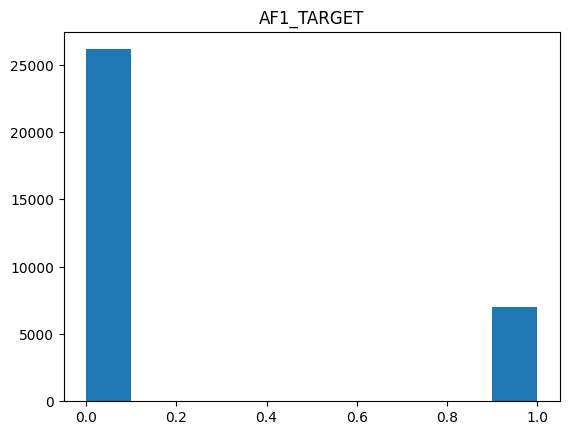

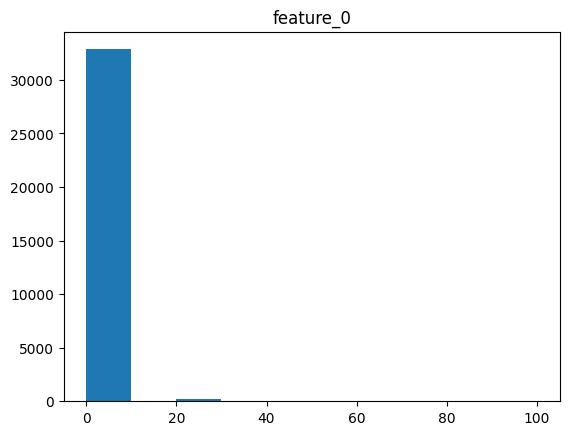

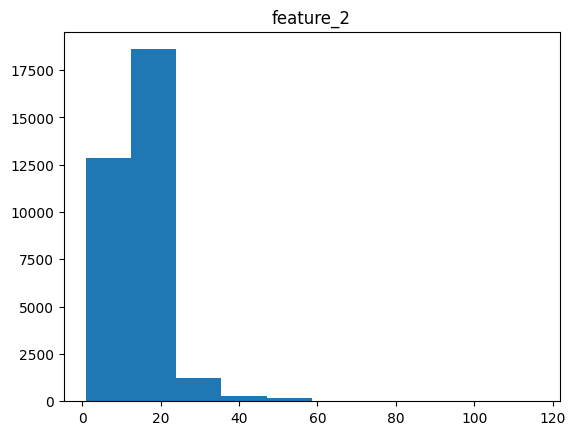

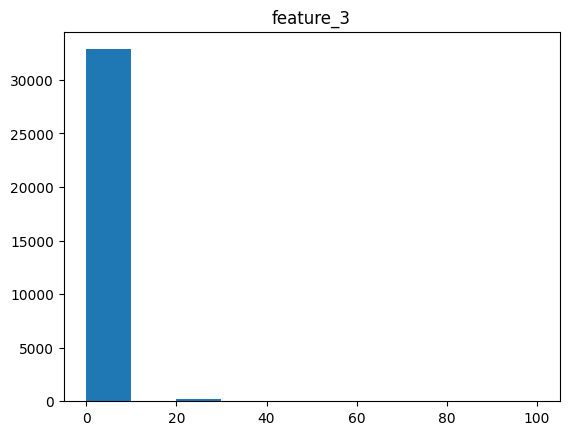

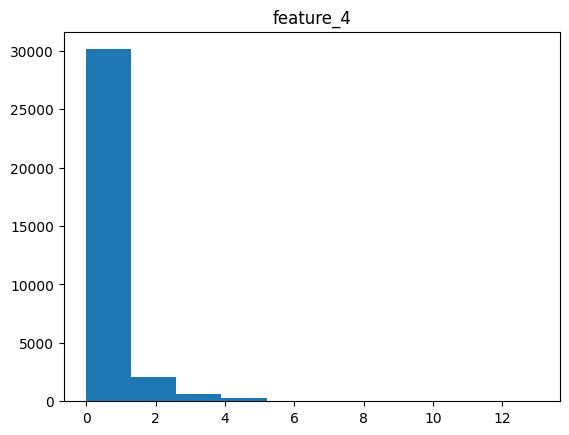

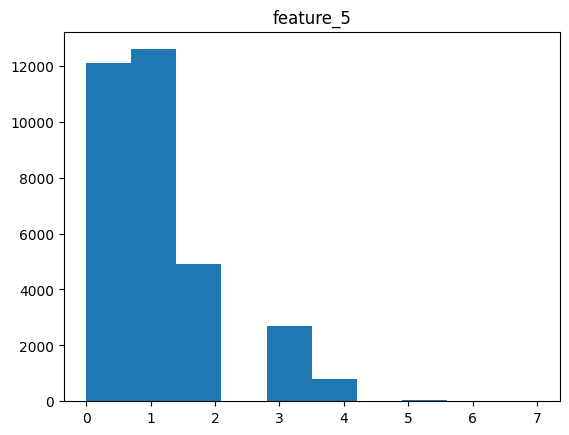

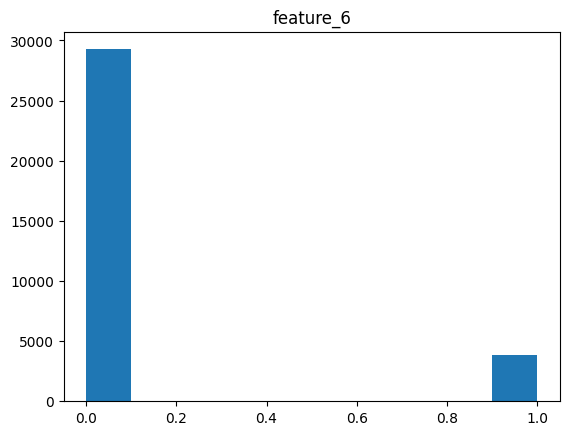

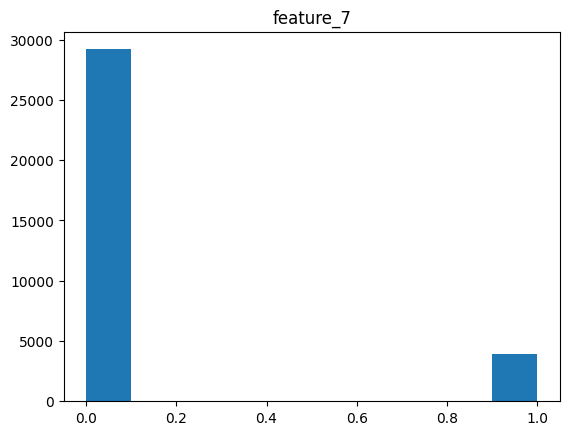

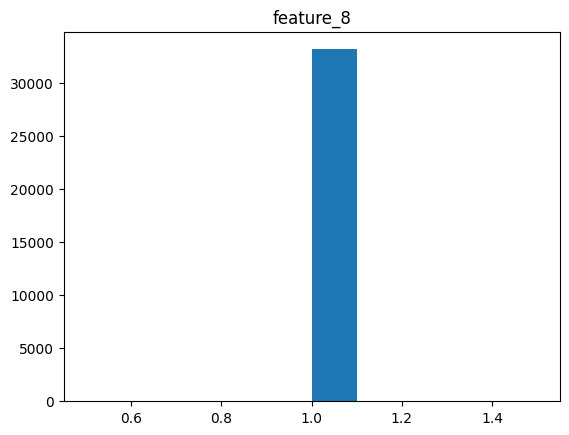

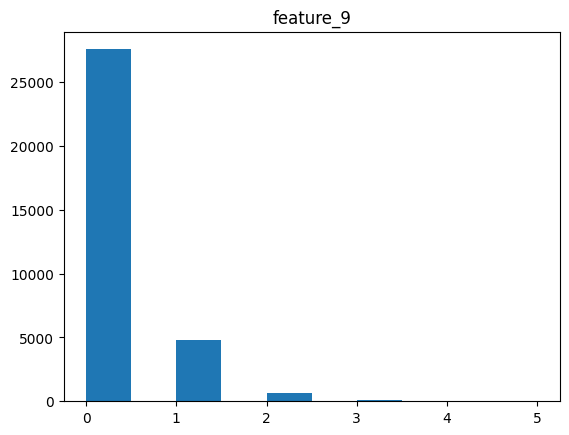

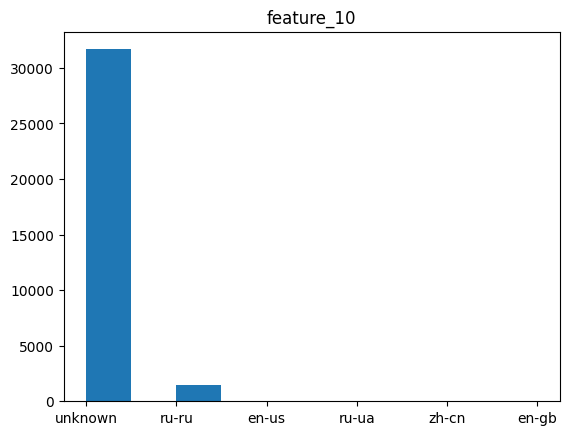

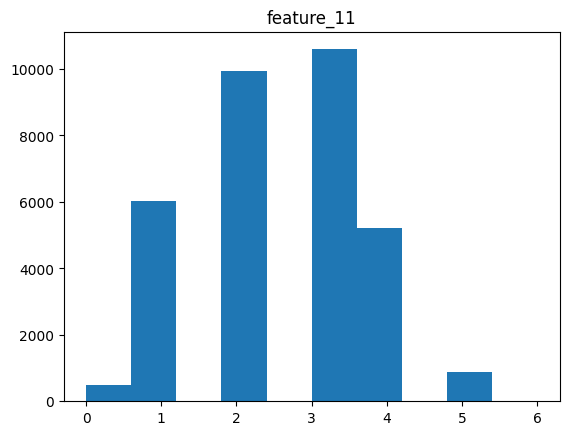

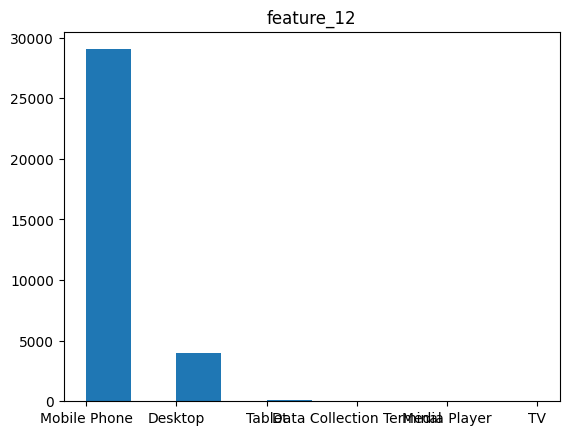

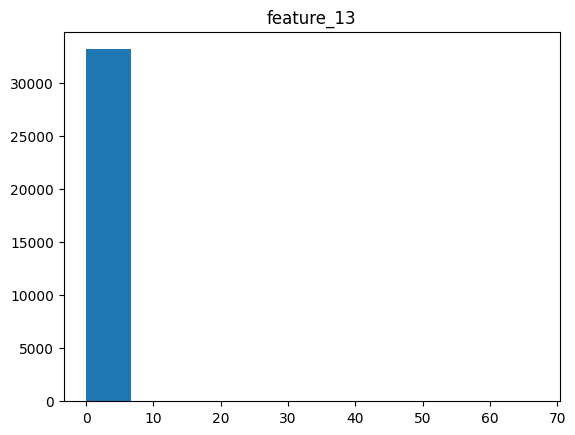

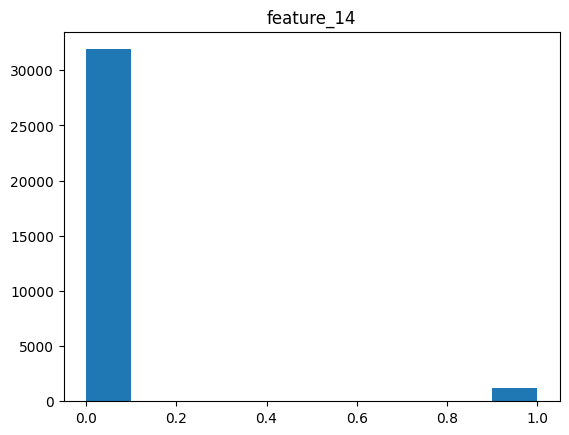

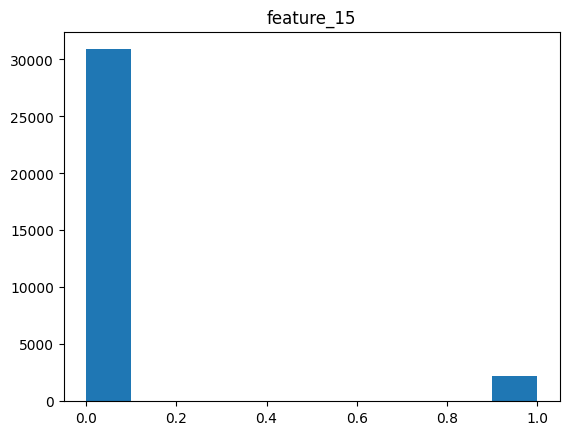

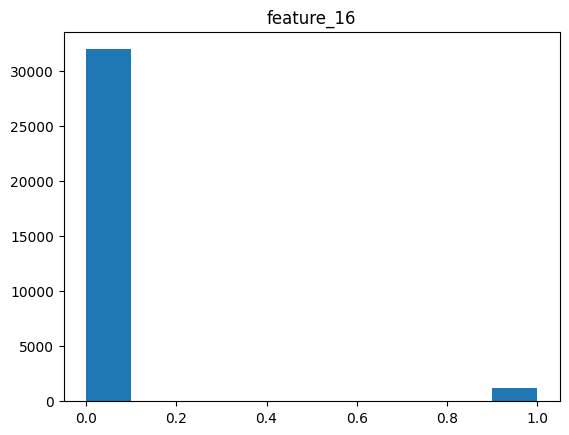

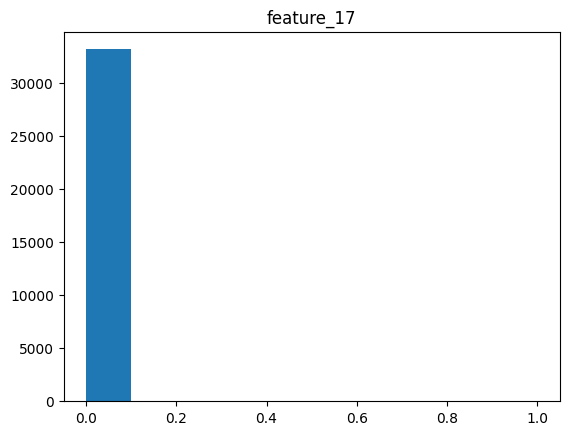

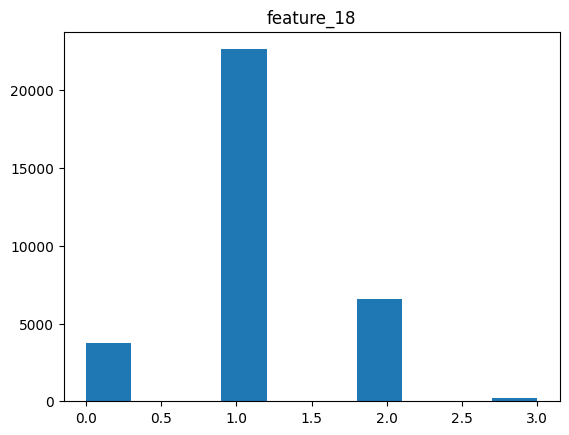

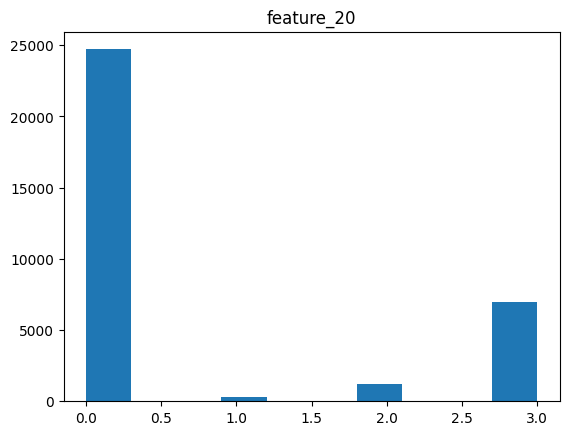

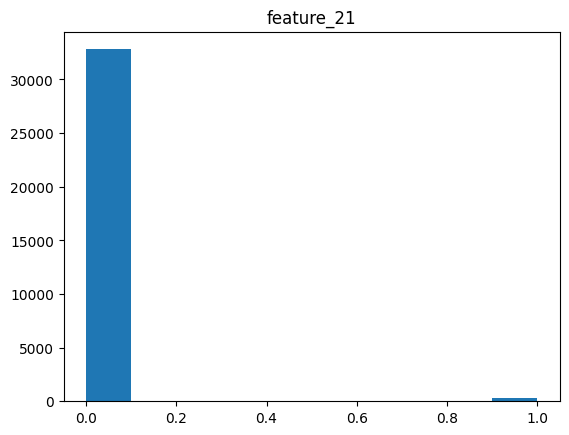

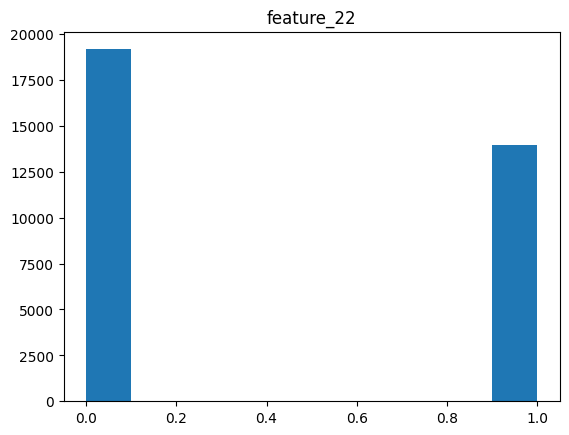

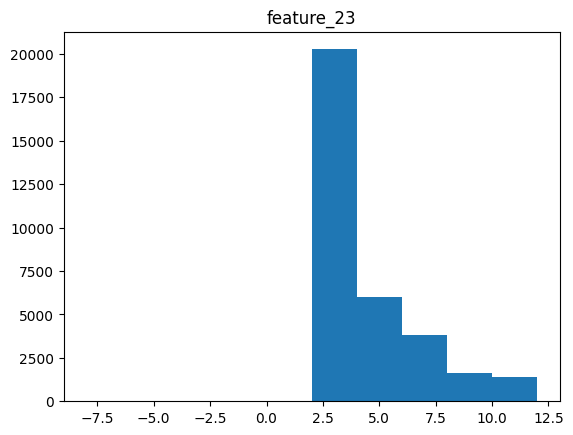

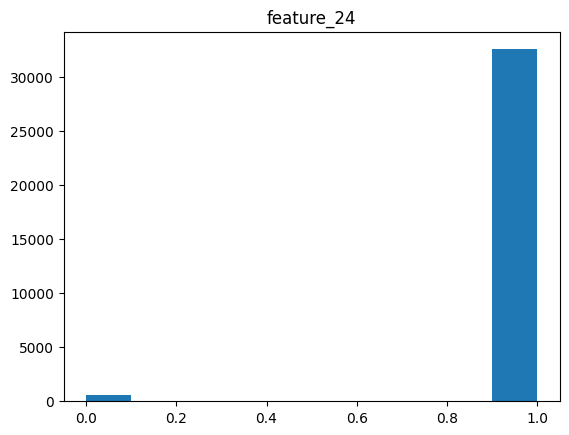

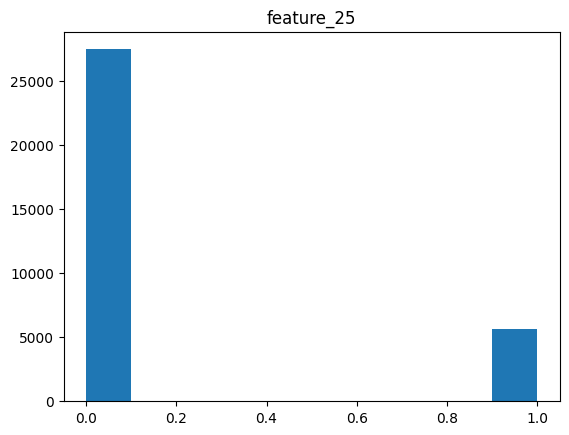

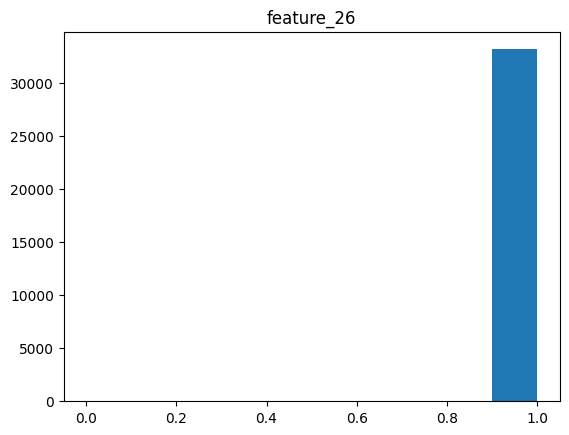

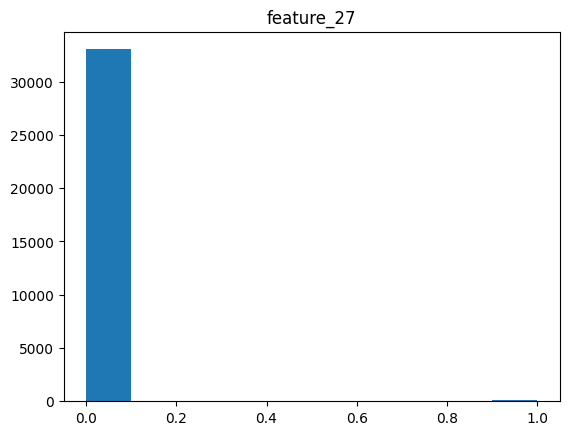

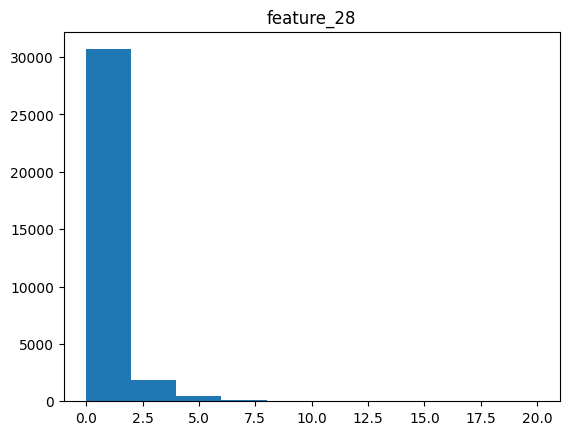

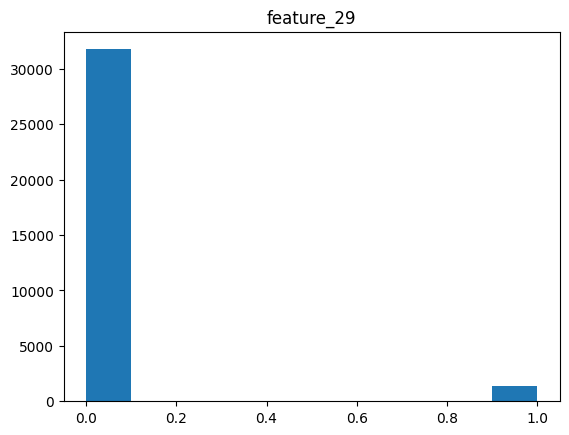

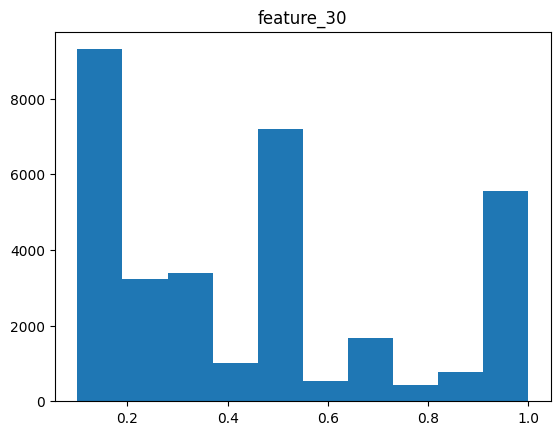

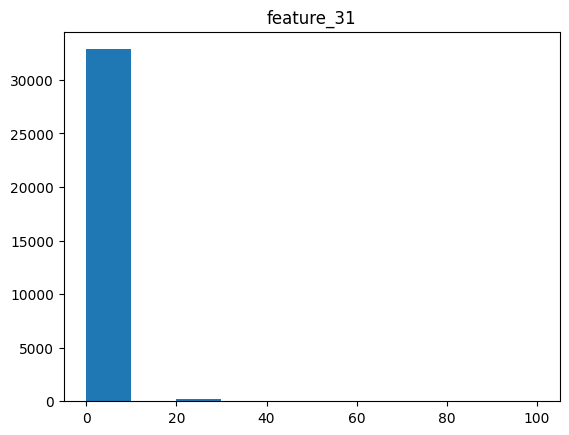

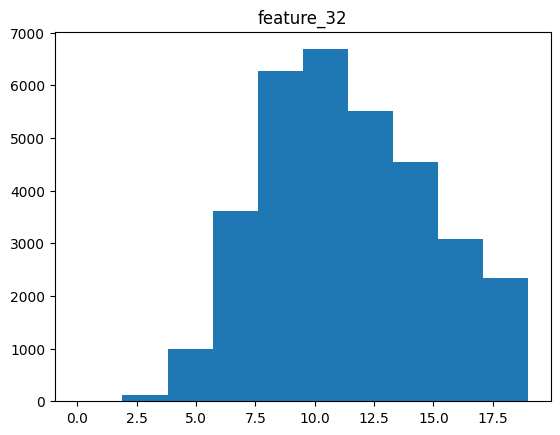

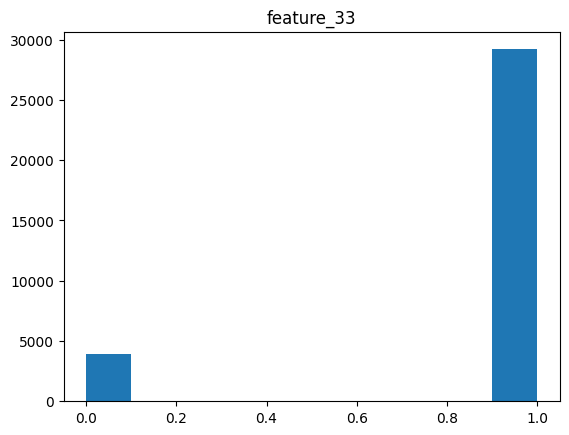

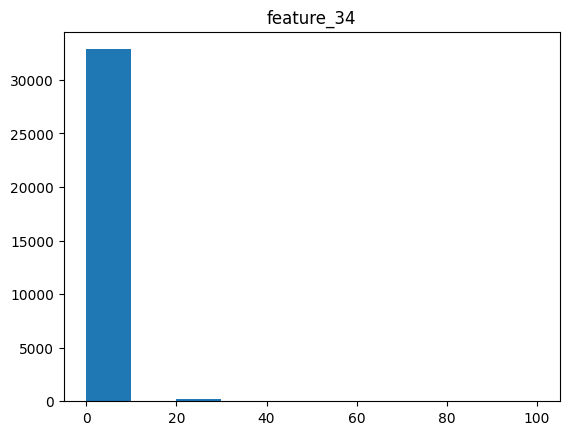

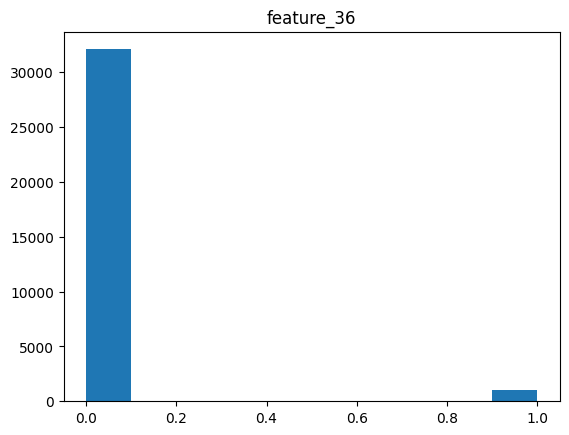

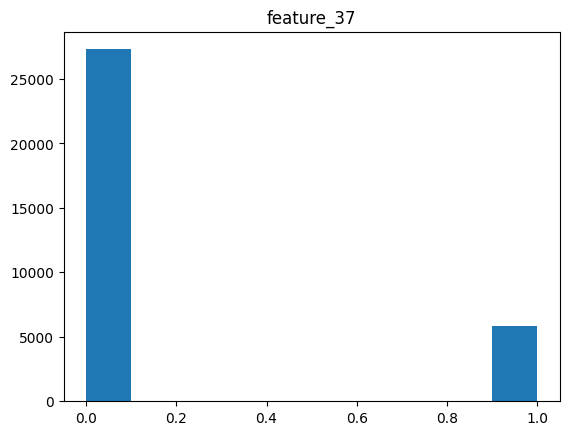

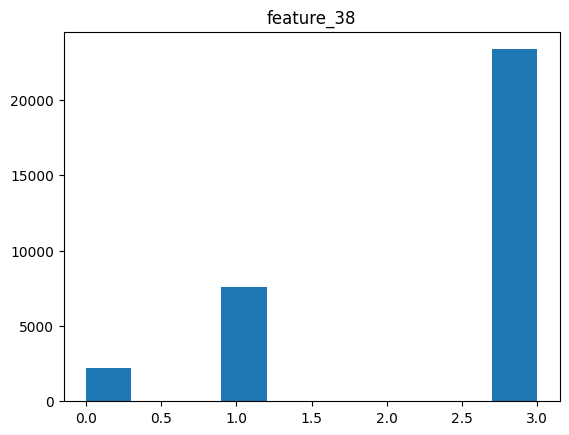

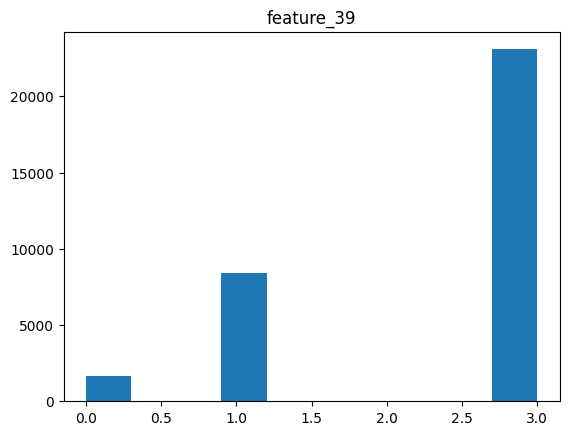

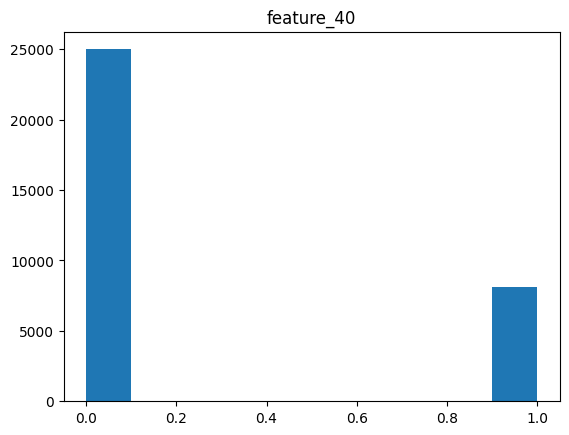

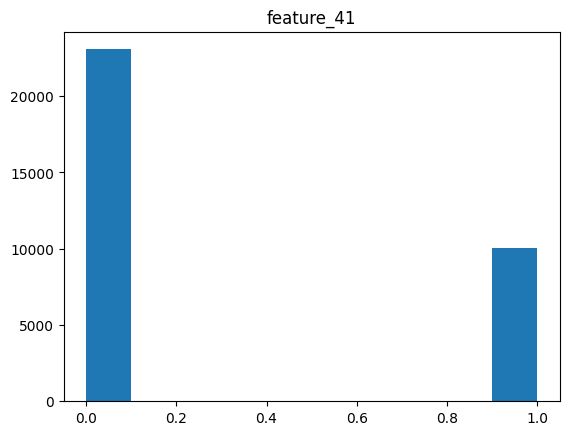

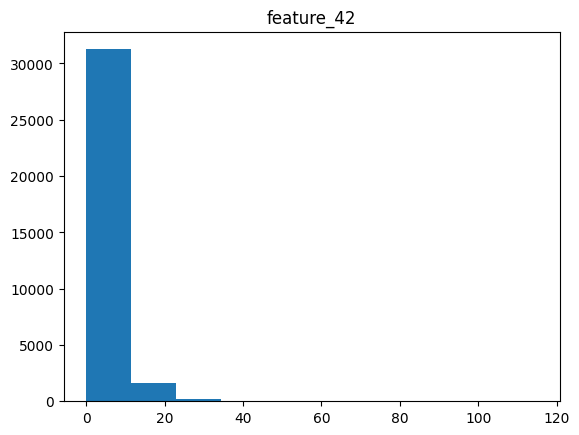

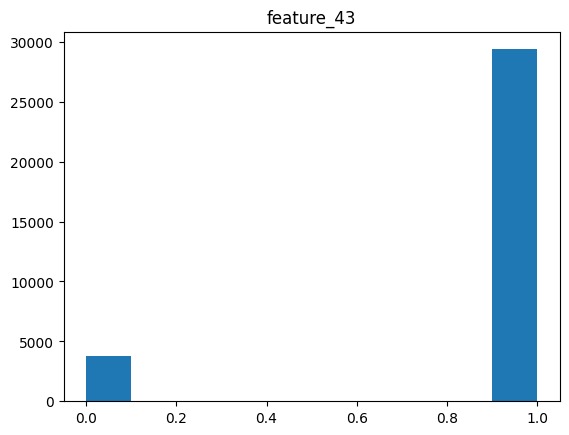

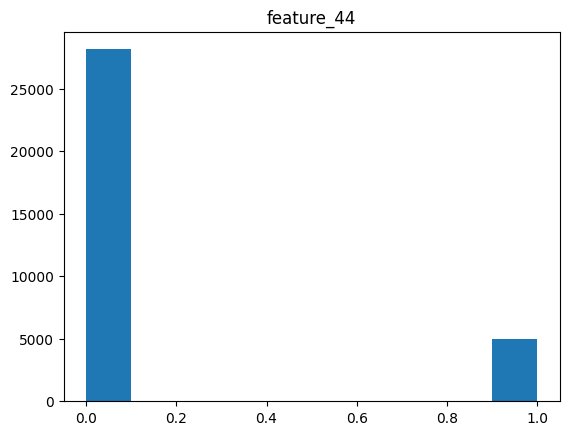

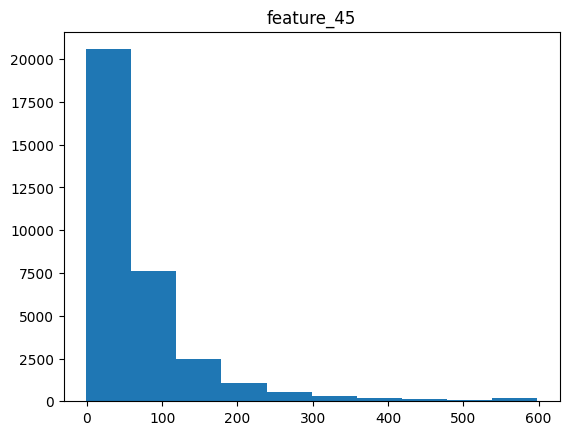

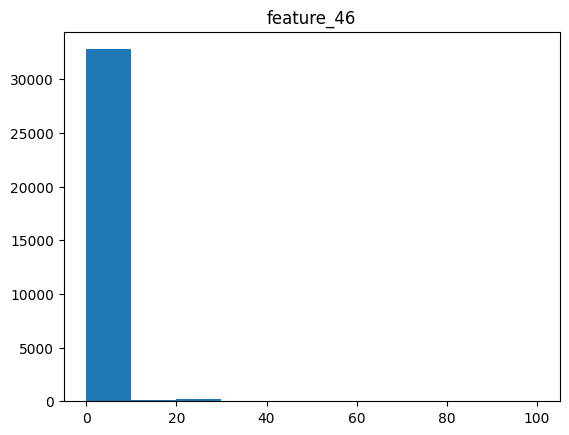

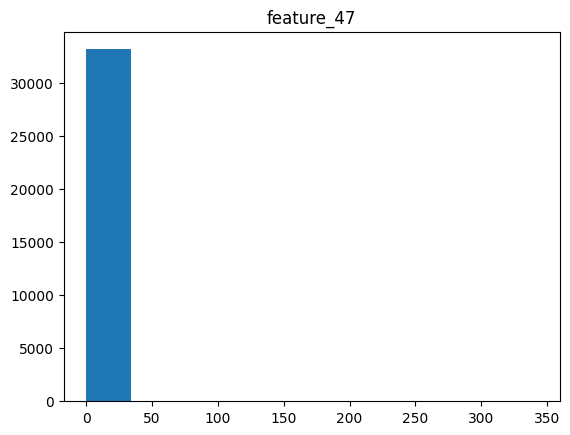

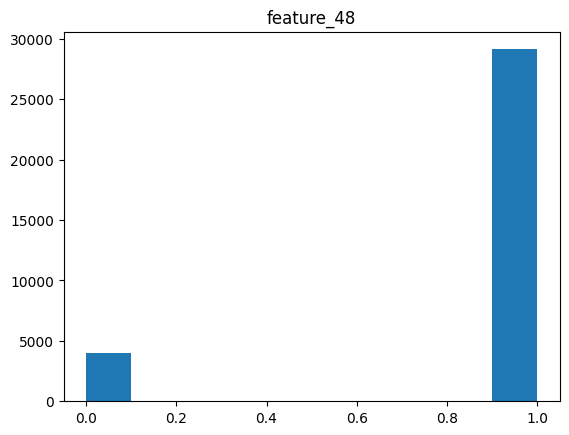

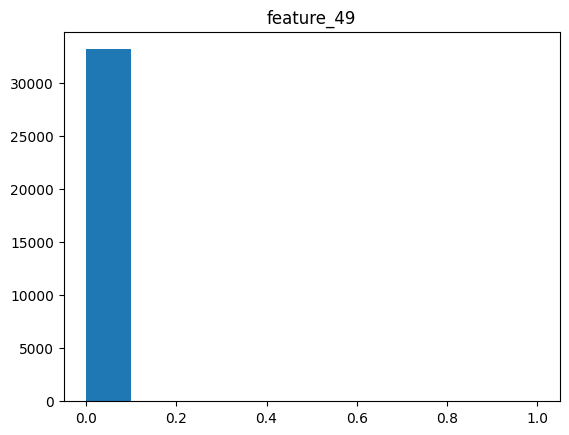

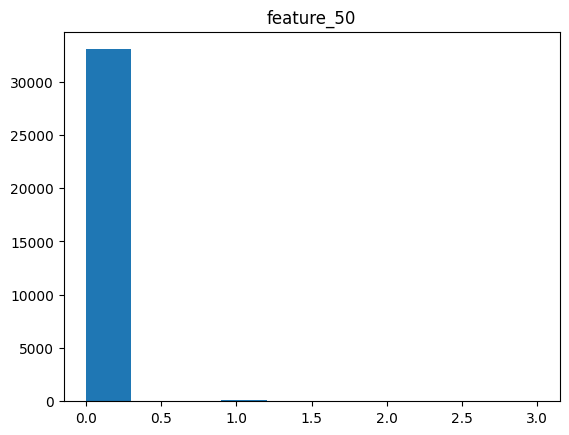

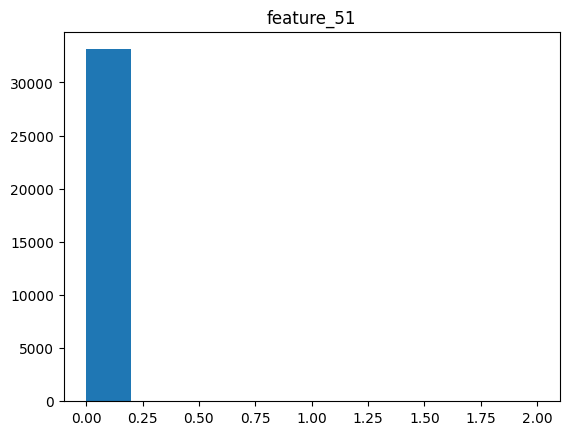

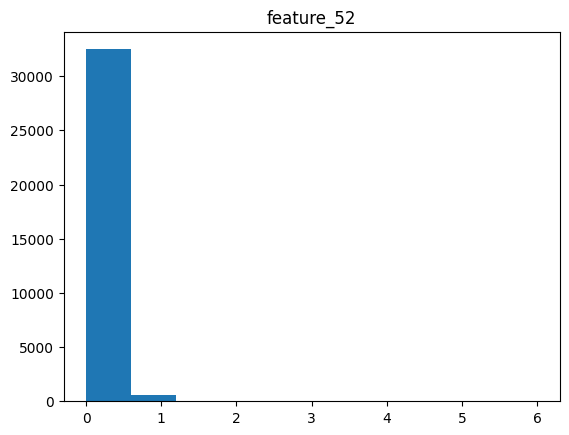

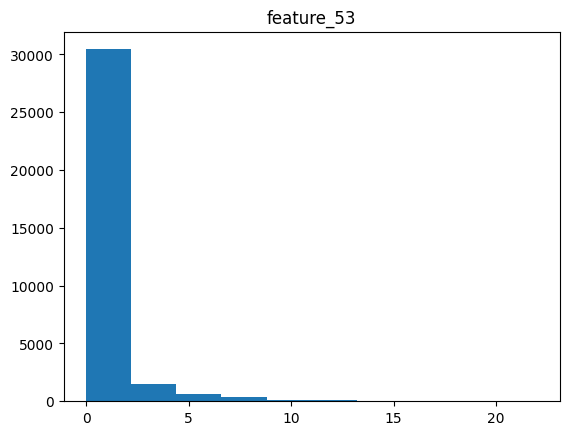

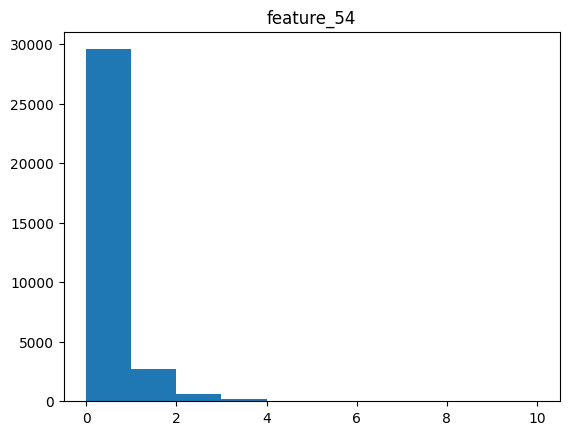

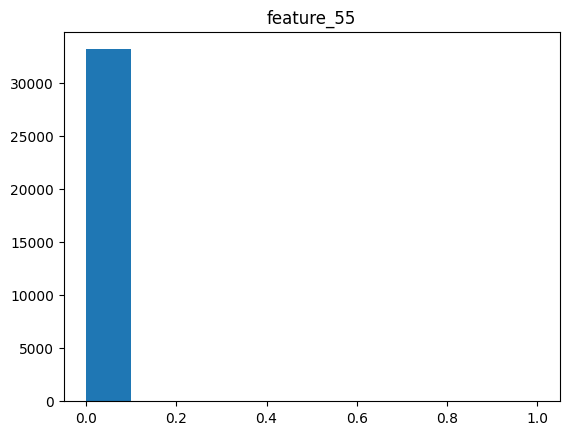

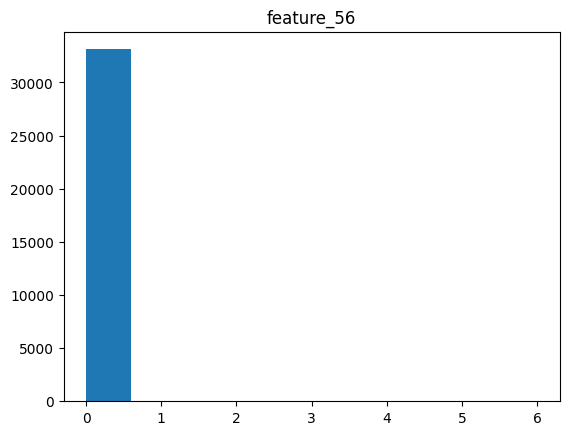

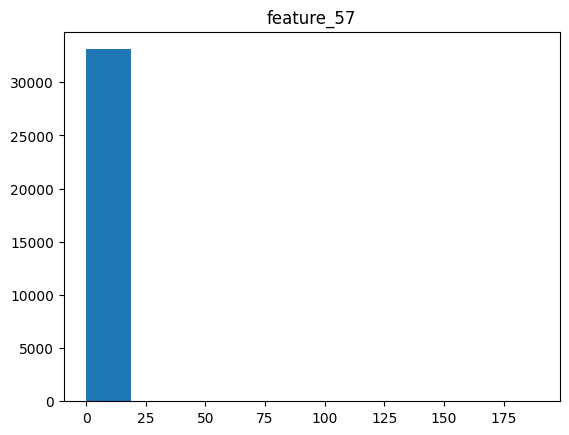

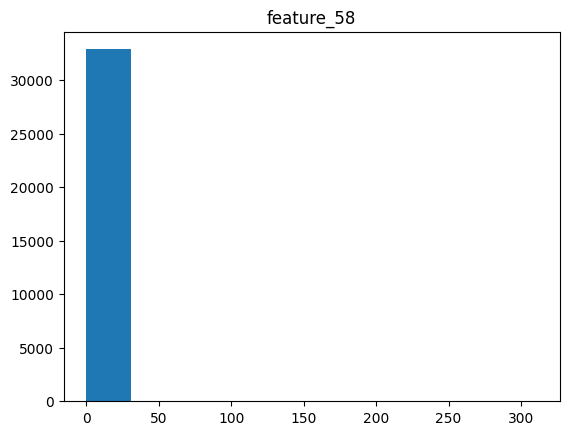

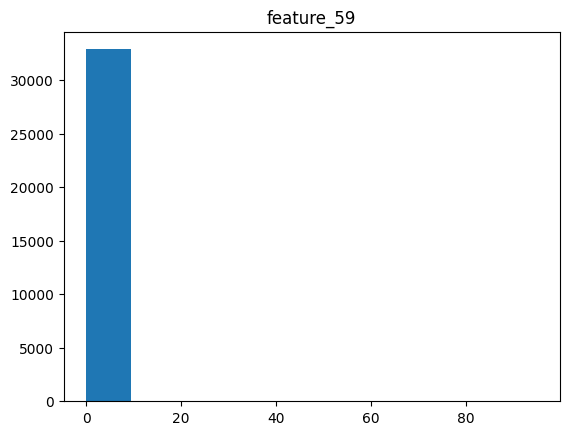

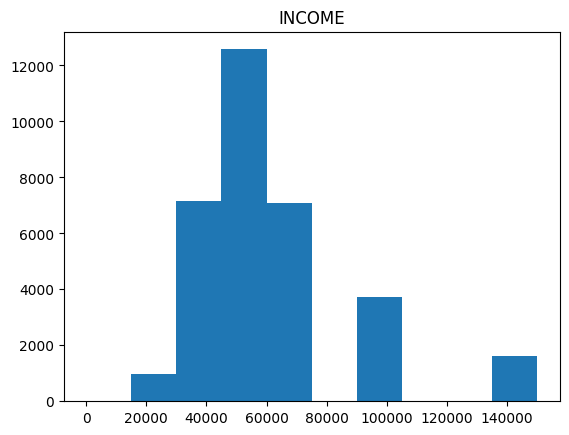

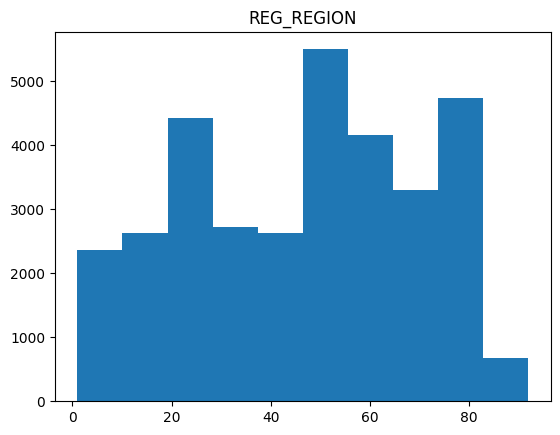

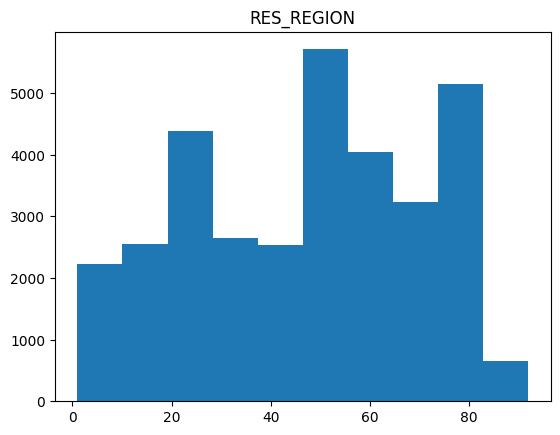

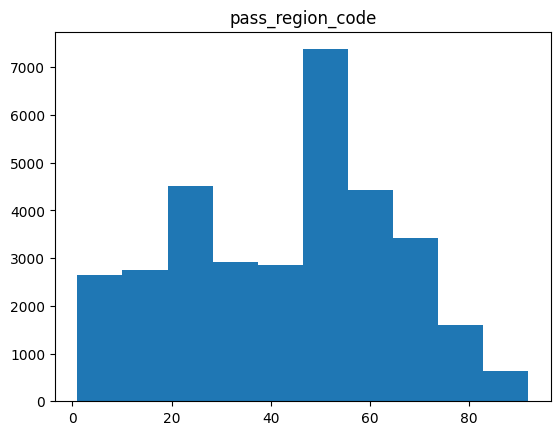

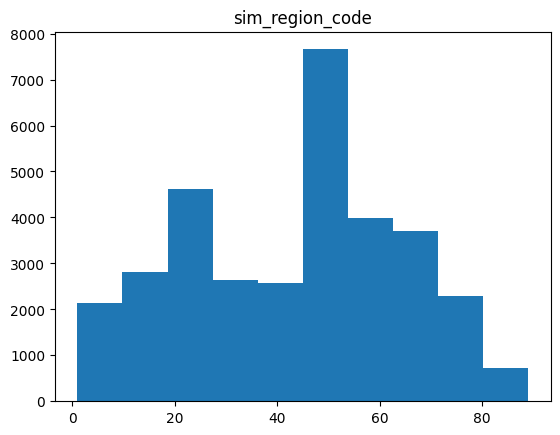

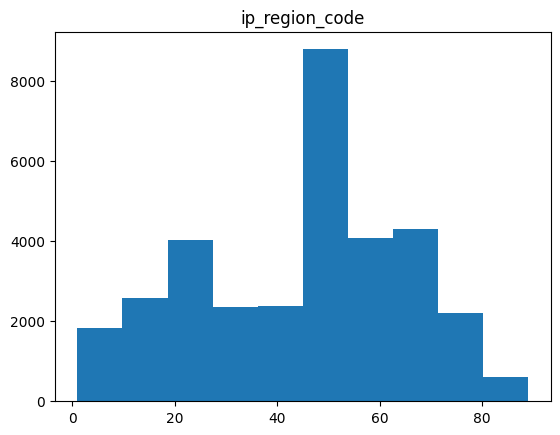

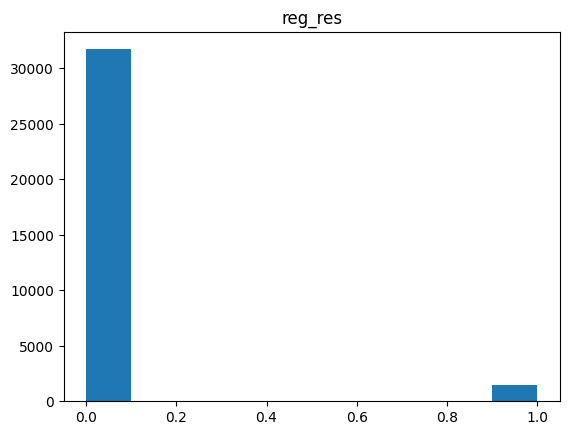

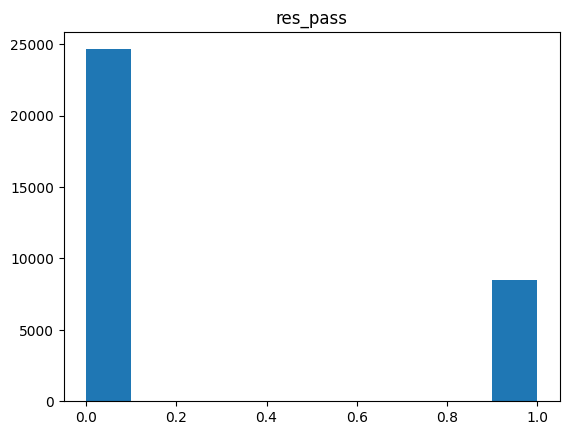

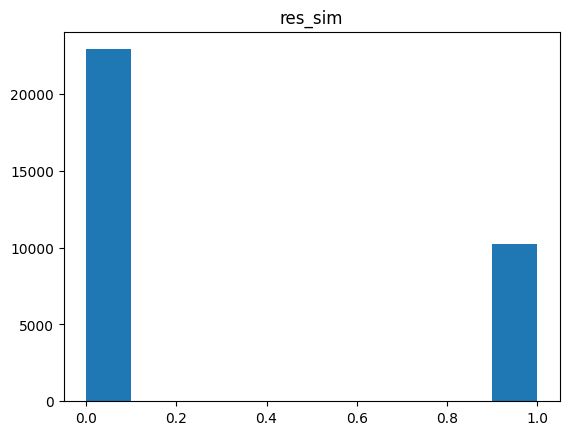

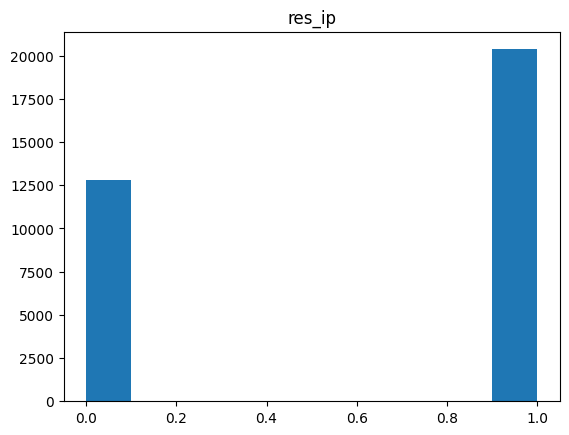

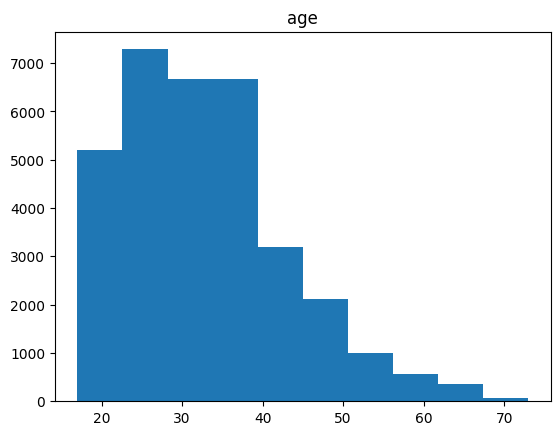

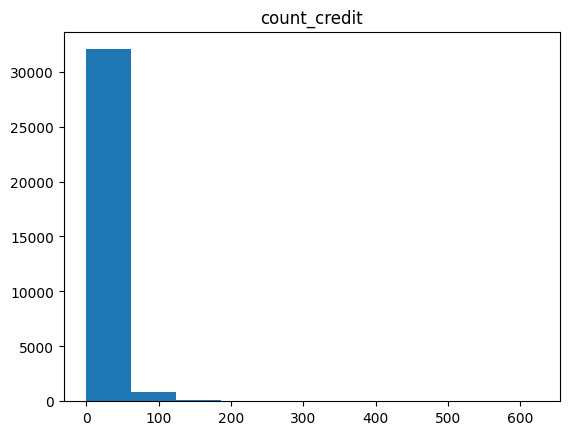

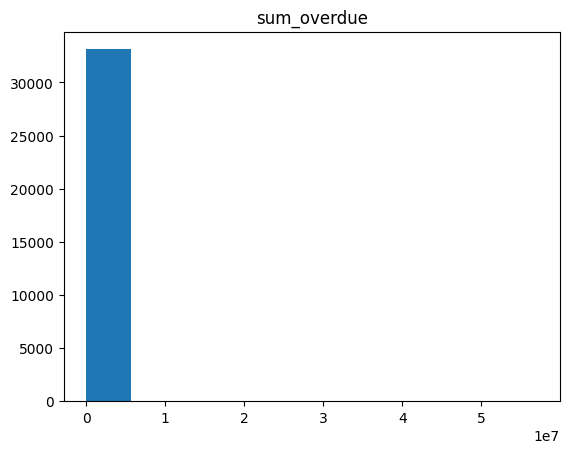

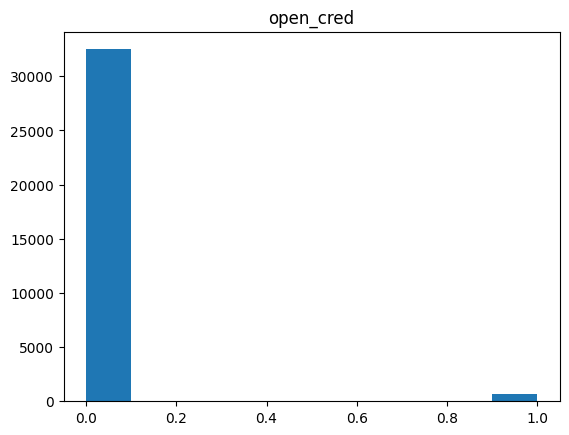

In [49]:
for i in data.drop(labels = ['ID','SAVE_STAMP', 'CARD_EXPIRY_DATE'], axis = 1).columns:
  plt.title(i)
  plt.hist(data[i])
  plt.show()



В целевой фиче у нас явный дисбаланс, что неудивительно, большинсво клиентов не являются мошенниками. feature_0 - есть люди, которые подали очень много заявлений, но большинство все таки до 20 шт, возможно стоит ограничить нашу выборку до 30-40 заявлений. feature_2 - так же есть достаточно большие выбросы, но большинство клиентов имеют небольшой размер истории в текущей сессии. feature_3 - большинство клиентов привязывают немного карт к своему устройству, но есть люди у которых этот показатель очень высокий, так же можно ограничить выборку. feature_4 - у большинства клиентов от 0 до 2 дополнительных городов. feature_8 имеет только одно значение - 1, удалим его. Очень много unknow в feature_10. Этот показатель не несет много смысловой нагрузки, лучше его удалить. Рассмотрим подробнее feature_12. Абсолютное большинство клиентов подают заявки с мобильного телефона, но есть и те кто пользуются планшетом, телевизором и прочими устройствами, посмотрим сколько таких. В feature_17 почти всегда 0, такой показатель нам не особо актуален. В feature_26 так же почти всегда 0, удалим ее. feature_34 отражает количество дополнительных номеров клиента, у большинства до 20 телефонов, можно ограничить выборку до 20-30. feature_47 имеет большой выброс, можно ограничить его до медианных значений.

Удалим feature_10 и рассмотрим поближе feature_12

In [50]:
data = data.drop(labels = ['feature_10'], axis = 1)

In [51]:
data['feature_12'].value_counts()

Mobile Phone                29041
Desktop                      4004
Tablet                         96
TV                              2
Data Collection Terminal        1
Media Player                    1
Name: feature_12, dtype: int64

Совсем мало пользователей Tablet, TV, Data Collection Terminal, Media Player. Объединим их в одну категорию Other

In [52]:
data['feature_12'] = data['feature_12'].replace(['Tablet', 'TV', 'Data Collection Terminal', 'Media Player'],['Other','Other','Other','Other'])

data['feature_12'].value_counts()

Mobile Phone    29041
Desktop          4004
Other             100
Name: feature_12, dtype: int64

In [53]:
data.head()

,ID,AF1_TARGET,feature_0,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,SAVE_STAMP,INCOME,CARD_EXPIRY_DATE,REG_REGION,RES_REGION,pass_region_code,sim_region_code,ip_region_code,reg_res,res_pass,res_sim,res_ip,age,count_credit,sum_overdue,open_cred
0,19623760,0,1,12,1,5,2,0,0,1,0,2,Mobile Phone,0,0,1,0,0,1,3,0,0,3.0,1,0,1,0,0,0,0.50,0,15,1,0,0,0,1,1,1,1,2,1,1,27.0,11,0.000,1,0,0,0,0,2,0,0,0,5,1,1,2022-03-01 10:52:15,70000,2025-11-30 23:59:59,2,2,16,16,34,0,1,1,1,45,11,0,0
1,19623933,1,0,14,0,0,1,0,1,1,0,2,Desktop,1,0,0,0,0,3,0,0,0,3.0,1,0,1,0,0,0,0.93,0,17,0,0,1,0,3,3,0,0,8,0,0,13.0,0,0.103,0,0,0,0,0,0,0,0,0,0,0,0,2022-03-01 10:56:41,100000,2024-12-31 23:59:59,78,78,60,38,47,0,1,1,1,43,9,0,0
2,19624038,0,1,4,0,1,0,0,1,1,0,5,Desktop,0,0,0,0,0,1,3,0,1,3.0,1,0,1,0,0,0,0.50,0,7,0,0,0,1,1,1,1,1,2,0,0,5.0,3,0.103,0,0,0,0,0,0,0,0,0,0,1,1,2022-03-01 10:59:19,70000,2024-04-30 23:59:59,78,78,47,47,47,0,1,1,1,34,12,301636,0
3,19624979,1,0,15,0,0,2,0,1,1,0,3,Desktop,0,0,0,0,0,1,0,1,0,3.0,1,0,1,0,1,0,1.00,0,6,0,0,1,0,3,3,0,0,8,0,0,122.0,0,0.103,0,0,0,0,0,0,0,0,0,0,0,0,2022-03-01 11:24:10,150000,2026-11-30 23:59:59,23,23,23,16,23,0,0,1,0,35,14,0,0
4,19625054,1,0,12,0,0,1,1,0,1,0,1,Mobile Phone,0,0,0,0,0,2,0,0,0,3.0,1,0,1,0,0,0,0.13,0,6,1,0,0,0,3,3,0,0,3,1,0,58.0,0,1.098,1,0,0,0,0,0,0,0,0,0,0,0,2022-03-01 11:25:46,50000,2025-01-31 23:59:59,62,62,62,62,50,0,0,0,1,24,41,173950,0


Удалим ненужные feature.

In [54]:
data = data.drop(labels = ['feature_8', 'feature_17', 'feature_26'], axis = 1)

Посмотрим выбросы более подробно, чтобы ограничить выборку

<Axes: >

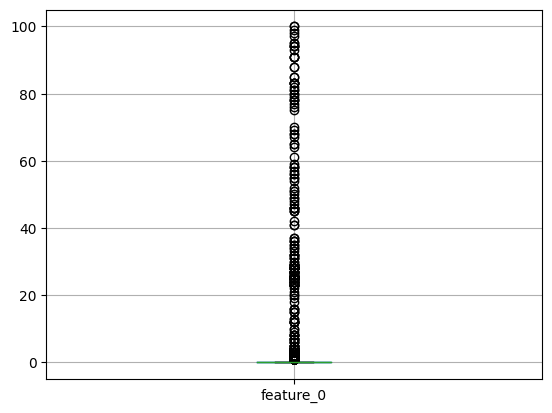

In [55]:
data.boxplot(column=['feature_0'])

<Axes: >

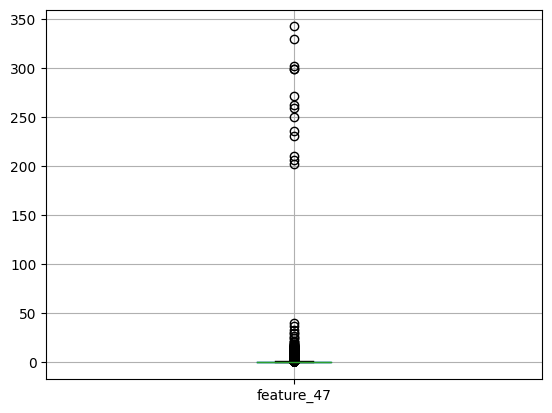

In [56]:
data.boxplot(column=['feature_47'])

<Axes: >

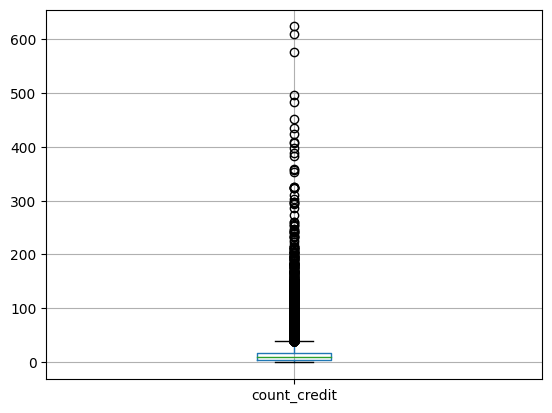

In [57]:
data.boxplot(column=['count_credit'])

Очень много выбросов, лучше их ограничить, для улучшения обучения модели.

In [58]:
data = data.loc[(data['feature_0'] < 15) &
                 (data['feature_47'] < 30) &
                 (data['count_credit'] < 90)]


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32356 entries, 0 to 33144
Data columns (total 71 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID                32356 non-null  int64         
 1   AF1_TARGET        32356 non-null  int64         
 2   feature_0         32356 non-null  int64         
 3   feature_2         32356 non-null  int64         
 4   feature_3         32356 non-null  int64         
 5   feature_4         32356 non-null  int64         
 6   feature_5         32356 non-null  int64         
 7   feature_6         32356 non-null  int64         
 8   feature_7         32356 non-null  int64         
 9   feature_9         32356 non-null  int64         
 10  feature_11        32356 non-null  int64         
 11  feature_12        32356 non-null  object        
 12  feature_13        32356 non-null  int64         
 13  feature_14        32356 non-null  int64         
 14  feature_15        3235

В принципе мы удалили не так много строк, в районе 1000, не очень приятно, но так будет лучше.

Проверим корреляцию признаков, чтобы удалить коррелирующие в случае необходимости

In [61]:
data_corr = data.drop(labels = ['ID', 'AF1_TARGET', 'feature_6', 'feature_7', 'feature_14', 'feature_14', 'feature_15', 'feature_16', 'feature_21', 'feature_22',
                  'feature_24', 'feature_25', 'feature_27', 'feature_29', 'feature_33', 'feature_36', 'feature_37', 'feature_40', 'feature_41',
                  'feature_43', 'feature_44', 'feature_48', 'feature_49', 'feature_55', 'reg_res', 'res_pass', 'res_sim', 'res_ip', 'count_credit'], axis = 1)
data_corr.corr()

<ipython-input-61-2019f9cceb75>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_corr.corr()


,feature_0,feature_2,feature_3,feature_4,feature_5,feature_9,feature_11,feature_13,feature_18,feature_20,feature_23,feature_28,feature_30,feature_31,feature_32,feature_34,feature_38,feature_39,feature_42,feature_45,feature_46,feature_47,feature_50,feature_51,feature_52,feature_53,feature_54,feature_56,feature_57,feature_58,feature_59,INCOME,REG_REGION,RES_REGION,pass_region_code,sim_region_code,ip_region_code,age,sum_overdue,open_cred
feature_0,1.000000,-0.118532,0.672382,0.337443,-0.029958,0.318724,-0.075566,-0.002326,-0.016891,0.146732,0.024322,-0.023405,-0.055022,0.649067,-0.000142,0.695195,-0.375340,-0.382108,-0.005435,-0.052593,0.486846,-0.028907,0.001773,-0.002653,-0.001224,0.009333,0.009554,-0.002247,0.012956,0.253757,0.189961,-0.033233,-0.008013,-0.008074,-0.004850,-0.011415,-0.006463,-0.003974,0.002115,0.001675
feature_2,-0.118532,1.000000,-0.013197,-0.097603,0.034625,-0.084834,0.128715,0.002364,0.017141,-0.056176,-0.004247,0.068314,0.066951,-0.006788,-0.031640,0.011368,0.034553,0.032209,0.092461,0.021413,-0.093307,0.079788,0.005669,0.004611,-0.011003,-0.024876,-0.024224,0.003054,-0.015100,-0.013985,0.015010,0.111768,0.012928,0.015358,0.004075,-0.000857,0.002643,-0.037923,-0.005053,0.008113
feature_3,0.672382,-0.013197,1.000000,0.171867,0.001605,0.126828,-0.042134,-0.002752,-0.007008,0.055335,0.022485,-0.005011,-0.023956,0.542370,0.017090,0.583347,-0.217715,-0.220067,-0.018579,-0.043099,0.353094,-0.021847,-0.005487,-0.003581,0.007856,0.012678,0.010286,-0.002646,0.009818,0.289567,0.208000,-0.013050,-0.002909,-0.004389,0.000546,-0.002559,-0.000398,0.002284,-0.002125,-0.010308
feature_4,0.337443,-0.097603,0.171867,1.000000,-0.078514,0.452269,-0.045473,-0.006009,-0.033419,0.289952,-0.023508,-0.021542,-0.056804,0.281863,0.107512,0.218077,-0.313176,-0.322439,-0.029856,-0.030809,0.707380,0.047996,0.044470,0.008007,0.015829,0.039108,0.023458,0.021087,0.012992,0.117261,0.135653,-0.049827,-0.026450,-0.025772,-0.008289,0.009840,-0.007181,-0.074485,-0.016982,-0.026082
feature_5,-0.029958,0.034625,0.001605,-0.078514,1.000000,-0.003705,-0.017230,0.005423,-0.145200,-0.362935,0.158168,0.014941,0.014450,0.042510,0.006466,0.038133,0.256346,0.264792,0.026853,0.022181,-0.133042,-0.043790,-0.000652,-0.006736,0.047468,0.167318,0.119548,0.000776,0.050691,-0.038068,-0.112746,0.003521,-0.097640,-0.108013,-0.066569,-0.088367,-0.057047,0.019185,-0.011723,0.037219
feature_9,0.318724,-0.084834,0.126828,0.452269,-0.003705,1.000000,-0.089140,-0.006165,-0.027616,0.015943,0.008996,-0.027992,-0.035824,0.272589,0.135383,0.283907,-0.096669,-0.102422,-0.012797,-0.010154,0.450030,-0.055586,0.007250,0.001056,0.003584,0.017160,0.010361,-0.000960,0.010347,0.043639,0.030200,-0.063389,-0.015822,-0.015590,-0.000045,0.006420,-0.009942,-0.026115,-0.007025,-0.001251
feature_11,-0.075566,0.128715,-0.042134,-0.045473,-0.017230,-0.089140,1.000000,-0.001698,0.060684,0.007555,-0.035382,0.063890,0.153516,-0.039211,-0.082330,-0.051756,0.014913,0.011855,0.078728,-0.006395,-0.034782,0.287769,0.013918,0.006452,-0.019134,-0.060164,-0.039286,0.013584,-0.028065,-0.008043,-0.000058,0.225808,0.035971,0.039320,-0.000098,-0.022105,-0.002433,-0.169163,-0.022141,0.058771
feature_13,-0.002326,0.002364,-0.002752,-0.006009,0.005423,-0.006165,-0.001698,1.000000,-0.005384,-0.002579,-0.001280,0.109297,0.004491,-0.001938,-0.000446,-0.000785,0.000214,0.001665,0.166327,0.069615,-0.006226,0.002810,-0.001354,-0.000030,-0.003456,0.001802,0.012337,0.001818,-0.001609,0.003893,0.001101,0.013384,0.010245,0.009516,0.009458,0.006214,-0.004375,0.005186,0.000040,0.005298
feature_18,-0.016891,0.017141,-0.007008,-0.033419,-0.145200,-0.027616,0.060684,-0.005384,1.000000,0.001278,-0.447783,0.016023,0.068891,-0.010879,-0.051718,-0.002020,0.000849,-0.000446,0.027067,0.015971,-0.018203,0.018456,0.006116,0.000451,-0.023936,-0.065601,-0.052704,0.002182,-0.046691,-0.000646,0.010218,0.167913,0.232611,0.256108,0.130686,0.124590,0.187085,0.016098,0.020331,0.004178
feature_20,0.146732,-0.056176,0.055335,0.289952,-0.

feature_3 и feature_0 имеют сильную корреляцию. feature_3 показывает сколько карт привязано к устройству, feature_0 - дополнительный заявления клиента. Дополнительные заявления выглядят более важным параметром.

feature_31, feature_34 и feature_0. Логично, что дополнительны почтовые логины и номера связаны с дополнительными заявлениями клиента.

feature_46 и feature_0 и вновь число дополнительных заявлений.

feature_58 и feature_59 дополнительные заявления за 7 дней и 31, думаю логичнее оставить 31.

feature_38, feature_39 и feature_20 соответствие индекса достоверности сильно коррелирует с почтой и телефоном, что весьма логично, хоть мы и вмешивались в эти показатели, логиченее выглядит оставить feature_20.

feature_45 и feature_42 - удаляем feature_42, так как мы в нем заполнял пропуски

feature_50 и feature_51 - удаляем feature_51 потому что включает только 7 дней

feature_53 и feature_54 - история такая же как и выше, действия предпринимаем такие же

REG_REGION и RES_REGION - коды региона регистрации и проживания сильно коррелируют, удалим регион регистрации.

In [62]:
data = data.drop(labels = ['feature_3', 'feature_31', 'feature_34', 'feature_38', 'feature_39',
                           'feature_42', 'feature_51', 'feature_54', 'feature_46', 'feature_58', 'feature_59', 'REG_REGION', 'pass_region_code', 'sim_region_code'], axis = 1)

Мы удалили коррелирующие признаки.

В процессе визуализации мы узнали, что у нас есть дисбаланс классов. Рассмотрим его более подробно.

In [63]:
data['AF1_TARGET'].value_counts()

0    25484
1     6872
Name: AF1_TARGET, dtype: int64

Хоть дисбаланс и есть в нашей выборке, попробуем его никак не исправлять и обучим модели на таких данных

Таким образом мы проанализировали наш датасет. Визуализировали данные и посмотрели как распределяются признаки. Удалили коррелирующие и бессмысленные столбцы. Так же удалили выбросы в некоторых столбцах, тем самым ограничили наш датасет, что так же должно повысить качество модели.

# Обучение моделей

Теперь самое интересное: обучение моделей. У нас задача классификации, для ее решения будем использовать 3 модели: CatBoost, LGBM и RandomForest. В качестве оценки выберем roc_auc. Но для начала разобьем датасет на выборки и закодируем категориальные признаки.

In [66]:
target = data['AF1_TARGET']
features = data.drop(['ID', 'AF1_TARGET', 'SAVE_STAMP', 'CARD_EXPIRY_DATE'], axis=1)

In [67]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.30,
                                                                            random_state=12345)

In [68]:
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)

print(features_train_ohe.shape)
print(features_test_ohe.shape)

(22649, 54)
(9707, 54)


Приступим непосредственно к машинному обучению. И начнем с CatBoost.

In [69]:
cat_best_roc_auc = 0
for estimators in range(100, 1101, 300):
    for rate in range(1, 10, 2):
        rate = rate/100
        model_cat = CatBoostClassifier(n_estimators=estimators,
                                   random_state=12345,
                                   learning_rate=rate)

        roc_auc = cross_val_score(model_cat,
                                  features_train_ohe,
                                  target_train,
                                  scoring = 'roc_auc',
                                  cv = 5)

        roc_auc_cat = np.mean(roc_auc)

        if roc_auc_cat > cat_best_roc_auc:
            cat_best_roc_auc = roc_auc_cat
            best_model_cat = model_cat
            best_estimators = estimators
            best_rate = rate

print(f'''
Лучшая модель при количестве деревьев {best_estimators},
скоросью обучения {best_rate} с оценкой {cat_best_roc_auc}
''')

Выходные данные были обрезаны до нескольких последних строк (5000).
4:	learn: 0.5295477	total: 45.7ms	remaining: 9.09s
5:	learn: 0.5121362	total: 55ms	remaining: 9.11s
6:	learn: 0.4961902	total: 64.2ms	remaining: 9.11s
7:	learn: 0.4848205	total: 73.7ms	remaining: 9.13s
8:	learn: 0.4729830	total: 83ms	remaining: 9.14s
9:	learn: 0.4639007	total: 92.4ms	remaining: 9.15s
10:	learn: 0.4568461	total: 101ms	remaining: 9.09s
11:	learn: 0.4496370	total: 110ms	remaining: 9.06s
12:	learn: 0.4436752	total: 119ms	remaining: 9.05s
13:	learn: 0.4384530	total: 128ms	remaining: 9.03s
14:	learn: 0.4338953	total: 138ms	remaining: 9.06s
15:	learn: 0.4298120	total: 147ms	remaining: 9.06s
16:	learn: 0.4266311	total: 156ms	remaining: 9.03s
17:	learn: 0.4233638	total: 165ms	remaining: 8.99s
18:	learn: 0.4203933	total: 174ms	remaining: 8.98s
19:	learn: 0.4178931	total: 183ms	remaining: 8.97s
20:	learn: 0.4160002	total: 192ms	remaining: 8.95s
21:	learn: 0.4141110	total: 201ms	remaining: 8.95s
22:	learn: 0.41218

Метрика качества показывает 0.7909, посмотрим что покажут остальные.

In [70]:
lgbm_best_roc_auc = 0
for estimators in range(100, 1101, 300):
    for rate in range(1, 10, 2):
        rate = rate/10
        model_lgbm = LGBMClassifier(n_estimators=estimators,
                                   random_state=12345,
                                   learning_rate=rate)

        roc_auc = cross_val_score(model_lgbm,
                                  features_train_ohe,
                                  target_train,
                                  scoring = 'roc_auc',
                                  cv = 5)

        roc_auc_lgbm = np.mean(roc_auc)

        if roc_auc_lgbm > lgbm_best_roc_auc:
            lgbm_best_roc_auc = roc_auc_lgbm
            best_model_lgbm = model_lgbm
            best_estimators = estimators
            best_rate = rate

print(f'''
Лучшая модель при количестве деревьев {best_estimators},
скоросью обучения {best_rate} с оценкой {lgbm_best_roc_auc}
''')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3873, number of negative: 14246
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1379
[LightGBM] [Info] Number of data points in the train set: 18119, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.213754 -> initscore=-1.302447
[LightGBM] [Info] Start training from score -1.302447
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3873, number of negative: 14246
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col

Немного отстает LightGBM, посмотрим что у нас с лесом.

In [71]:
forest_best_roc_auc = 0
for est in range(50,500,100):
    model_tree = RandomForestClassifier(
        n_estimators=est,
        random_state=12345).fit(
            features_train_ohe,
            target_train)
    scores_roc_auc = cross_val_score(model_tree,
                                          features_train_ohe,
                                          target_train,
                                          scoring = 'roc_auc',
                                          cv = 5)
    mean_roc_auc = np.mean(scores_roc_auc)

    if mean_roc_auc > forest_best_roc_auc:
        forest_best_roc_auc = mean_roc_auc
        best_model_tree = model_tree
        best_est = est
print()
print(f"Лучшая модель при количестве деревьев {est}, с оценкой {forest_best_roc_auc}")


Лучшая модель при количестве деревьев 450, с оценкой 0.7809260297656764


Лес примерно как и LightGBM. Теперь объединим результаты наших моделей в таблицу и посмотрим победителя.

In [72]:
results = {
    'Model' : ['RandomForestClassifier', 'LGBMClassifier', 'CatBoostClassifier'],
    'roc_auc' :pd.Series([forest_best_roc_auc, lgbm_best_roc_auc, cat_best_roc_auc])
    }
display(pd.DataFrame(results))

,Model,roc_auc
0,RandomForestClassifier,0.780926
1,LGBMClassifier,0.786249
2,CatBoostClassifier,0.790915


Побеждает у нас CatBoostClassifier с результом 0.7909. Конечно можно было бы и лучше, но имеем то что имеем.


Таким образом, мы заканчиваем этап обучения моделей. На нем мы: выделили целевую фичу, разделили выборку на обучающую и тестовую (которой мы без сомнения воспользуемся позже), обработали категориальные признаки и попробовали 3 модели машинного обучения, на лучшей из которых проверим тестовые данны.

#Проверка модели на тестовых данных

Итак вот и настал этот час, исследование подходит к концу, а мы проверям модель на тестовых данных и идем дальше.

In [73]:
best_model_cat = CatBoostClassifier(n_estimators=700,
                                   random_state=12345,
                                   learning_rate=0.03).fit(
                                      features_train_ohe, target_train)

prediction = best_model_cat.predict(features_test_ohe)

0:	learn: 0.6760331	total: 41.8ms	remaining: 29.2s
1:	learn: 0.6601559	total: 90.5ms	remaining: 31.6s
2:	learn: 0.6450247	total: 139ms	remaining: 32.4s
3:	learn: 0.6311991	total: 192ms	remaining: 33.4s
4:	learn: 0.6186926	total: 231ms	remaining: 32.1s
5:	learn: 0.6066853	total: 270ms	remaining: 31.2s
6:	learn: 0.5948479	total: 329ms	remaining: 32.6s
7:	learn: 0.5845470	total: 373ms	remaining: 32.3s
8:	learn: 0.5754690	total: 416ms	remaining: 31.9s
9:	learn: 0.5657456	total: 460ms	remaining: 31.7s
10:	learn: 0.5570899	total: 505ms	remaining: 31.6s
11:	learn: 0.5490422	total: 548ms	remaining: 31.4s
12:	learn: 0.5418611	total: 579ms	remaining: 30.6s
13:	learn: 0.5343593	total: 607ms	remaining: 29.7s
14:	learn: 0.5279880	total: 651ms	remaining: 29.7s
15:	learn: 0.5224686	total: 694ms	remaining: 29.7s
16:	learn: 0.5165724	total: 741ms	remaining: 29.8s
17:	learn: 0.5117637	total: 788ms	remaining: 29.8s
18:	learn: 0.5065842	total: 814ms	remaining: 29.2s
19:	learn: 0.5021514	total: 840ms	remai

AUC-ROC: 0.7926891519129368


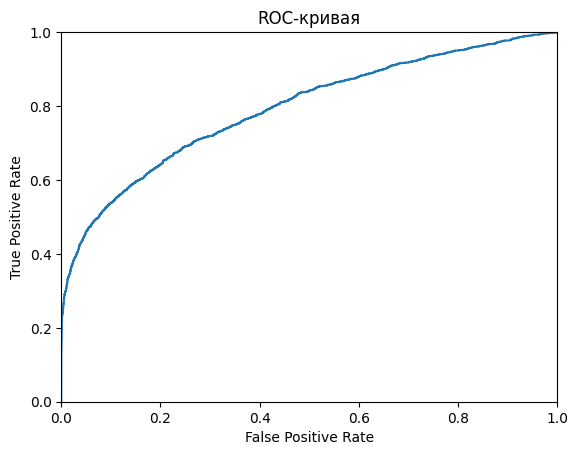

In [74]:
probabilities_cat = best_model_cat.predict_proba(features_test_ohe)
probabilities_one_cat = probabilities_cat[:,1]
fpr_cat,tpr_cat,thresholds = roc_curve(target_test,probabilities_one_cat)

auc_roc_cat = roc_auc_score(target_test,probabilities_one_cat)

print('AUC-ROC:', auc_roc_cat)

plt.figure()
plt.plot(fpr_cat, tpr_cat)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

На тестовых данных модель показала результат немного повыше. Так же построили roc-кривую для визуализации.

# Вывод

Таким образом, мы проанализировали датасет с данными клиентов, подающих заявки на кредит. Для начала мы предобработали наши данные: проверили наличие дубликатов, обработали пропуски, добавили новые столбцы, характеризующие наших клиентов. Так как у нас было несколько датасетов, объединили их в один. На следущем шаге мы исследовали датасет. Нашли признаки, которые принимают только одно значение и конечно же избавились от них. Посмотрели возраст наших клиентов, сколько кредитов они брали до этого. Узнали самое популярное устройство и что порой люди подают на кредит с TV. Убрали выбросы и коррелирующие признаки. На этапе обучения моделей мы проверили 3 модели и выбрали наилучшую. Это оказалась CatBoostClassifier, модель показала наилучший AUC-ROC. После мы посмотрели результат работы на тестовых данных. После проведенного исследования мы с увереностью можем рекомендовать компании модель CatBoostClassifier для антифрод системы. Так же, в целом для улучшения модели в будущем, лучше изучить датасет с кредитной историей и найти другие характеристики клиентов, вместо кодов регионов использовать наименование региона и закодировать его с помощью OHE, учитывать время когда подается заявление(как минимум день или ночь), можно попробовать удалять другие коррелирующие признаки, убрать еще больше выбросов и конечно же перебрать гиперпараметры выбранных моделей.